# Import packages & functions

In [1]:
# pip install matplotlib numpy torch torchvision torchaudio

In [2]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from tqdm import tqdm
from datetime import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:",device)

import ddp_config
distributed,local_rank = ddp_config.ddp_test()
if device=='cuda': torch.cuda.set_device(local_rank)

import utils
from models import Clipper, BrainNetwork, BrainDiffusionPrior

num_devices = torch.cuda.device_count()
if num_devices==0: num_devices = 1
num_workers = num_devices

seed=42
utils.seed_everything(seed=seed)

/fsx/nev/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: cuda
NOT using distributed parallel processing!


## Load CLIP extractor

In [3]:
clip_extractor = Clipper("ViT-L/14", 
                         clamp_embs=False, 
                         norm_embs=False, 
                         device=device)

ViT-L/14 cuda


# CLIP retrieval evaluation

### Load model checkpoint

In [5]:
model_name = "prior-w-voxel2clip"

outdir = f'../train_logs/models/{model_name}/test'

ckpt_path = os.path.join(outdir, f'ckpt-best.pth')
print("ckpt_path",ckpt_path)

checkpoint = torch.load(ckpt_path, map_location=device)

# utils.plot_brainnet_ckpt(ckpt_path)

ckpt_path ../train_logs/models/prior-w-voxel2clip/test/ckpt-best.pth


### Load pretrained weights onto model

In [6]:
voxel2clip = BrainNetwork(out_dim=768)

# need folder "checkpoints" with following files
# wget https://huggingface.co/nousr/conditioned-prior/raw/main/vit-l-14/aesthetic/prior_config.json
# wget https://huggingface.co/nousr/conditioned-prior/resolve/main/vit-l-14/aesthetic/best.pth
diffusion_prior = BrainDiffusionPrior.from_pretrained(
    dict(),
    dict(
        condition_on_text_encodings=False,
        timesteps=1000,
        voxel2clip=voxel2clip,
    ),
)

diffusion_prior.load_state_dict(checkpoint['model_state_dict'])
diffusion_prior.eval().to(device)
print("loaded")

loaded


### Prep data loader

In [7]:
batch_size = 300 # same as used in mind_reader

image_var = 'images'

train_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/train/train_subj01_{0..49}.tar"
val_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/val/val_subj01_0.tar"
meta_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/metadata_subj01.json"

voxels_key = 'nsdgeneral.npy' # 1d inputs
# voxels_key = 'wholebrain_3d.npy' #3d inputs

try:
    train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
        batch_size, image_var,
        num_devices=num_devices,
        num_workers=num_workers,
        train_url=train_url,
        val_url=val_url,
        meta_url=meta_url,
        num_samples=None,
        # seed=seed,
        voxels_key=voxels_key,
    )
except: # assuming error because urls were not valid
    print("Pulling data directly from huggingface...\n")
    train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
        batch_size, image_var,
        num_devices=num_devices,
        num_workers=num_workers,
        train_url=None,
        val_url=None,
        meta_url=None,
        num_samples=None,
        # seed=seed,
        voxels_key=voxels_key,
    )

# check that your data loader is working
for val_i, (voxel, img_input, key) in enumerate(val_dl):
    print("idx",val_i)
    print("voxel.shape",voxel.shape)
    print("img_input.shape",img_input.shape)
    print("key[:2]",key[:2])
    break

Getting dataloaders...
Pulling data directly from huggingface...

Getting dataloaders...
train_url https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/9947586218b6b7c8cab804009ddca5045249a38d/webdataset/train/train_subj01_{0..49}.tar
val_url https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/9947586218b6b7c8cab804009ddca5045249a38d/webdataset/val/val_subj01_0.tar
num_devices 8
num_workers 8
batch_size 300
val_batch_size 300
global_batch_size 2400
num_worker_batches 1
num_train 24983
num_val 492
cache_dir /tmp/wds-cache
validation: num_worker_batches 2


/fsx/nev/venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


.: directory
idx 0
voxel.shape torch.Size([300, 15724])
img_input.shape torch.Size([300, 3, 256, 256])
key[:2] ['sample00002', 'sample00013']


## Forward / Backward quantification

In [8]:
percent_correct_fwd, percent_correct_bwd = None, None

for val_i, (voxel, img, trial) in enumerate(val_dl):
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            voxel = voxel.to(device)
            
            emb = clip_extractor.embed_image(img) # CLIP-Image
            
            #emb = clip_extractor.embed_curated_annotations(subj01_annots[trial]) # CLIP-Text
            
            # l2norm + scaling 
            emb_ = nn.functional.normalize(diffusion_prior.voxel2clip(voxel),dim=-1) * diffusion_prior.image_embed_scale

            labels = torch.arange(len(emb)).to(device)
            bwd_sim = utils.batchwise_cosine_similarity(emb,emb_)  # clip, brain
            fwd_sim = utils.batchwise_cosine_similarity(emb_,emb)  # brain, clip

            if percent_correct_fwd is None:
                cnt=1
                percent_correct_fwd = utils.topk(fwd_sim, labels,k=1)
                percent_correct_bwd = utils.topk(bwd_sim, labels,k=1)
            else:
                cnt+=1
                percent_correct_fwd += utils.topk(fwd_sim, labels,k=1)
                percent_correct_bwd += utils.topk(bwd_sim, labels,k=1)
percent_correct_fwd /= cnt
percent_correct_bwd /= cnt
print("fwd percent_correct", percent_correct_fwd)
print("bwd percent_correct", percent_correct_bwd)

.: directory
.: directory
.: directory
fwd percent_correct tensor(0.4800, device='cuda:0')
bwd percent_correct tensor(0.6233, device='cuda:0')


### Plot some of the results

Forward retrieval


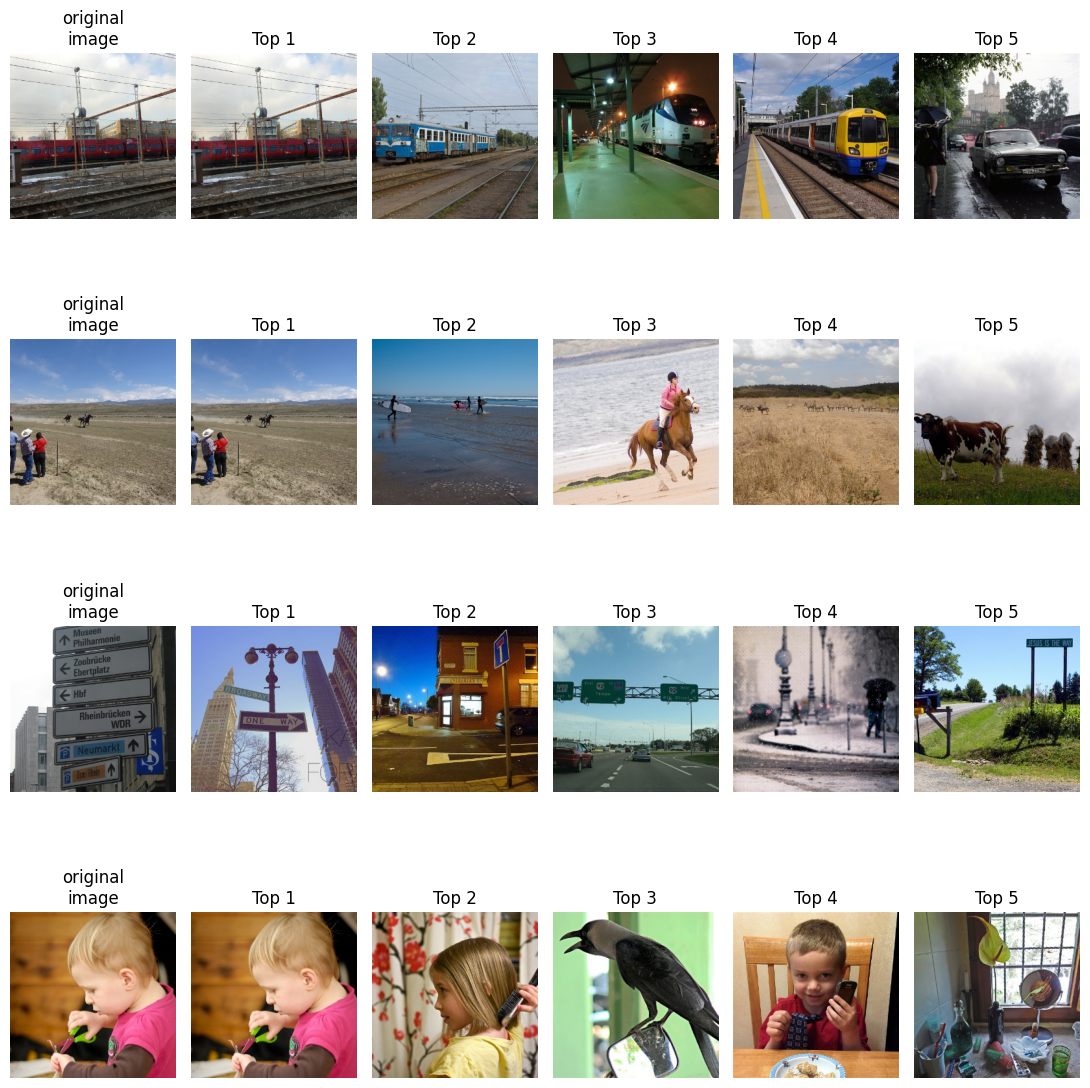

In [9]:
print("Forward retrieval")
try:
    fwd_sim = np.array(fwd_sim.cpu())
except:
    fwd_sim = np.array(fwd_sim)
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(11,12))
for trial in range(4):
    ax[trial, 0].imshow(utils.torch_to_Image(img[trial]))
    ax[trial, 0].set_title("original\nimage")
    ax[trial, 0].axis("off")
    for attempt in range(5):
        which = np.flip(np.argsort(fwd_sim[trial]))[attempt]
        ax[trial, attempt+1].imshow(utils.torch_to_Image(img[which]))
        ax[trial, attempt+1].set_title(f"Top {attempt+1}")
        ax[trial, attempt+1].axis("off")
fig.tight_layout()
plt.show()

Backward retrieval


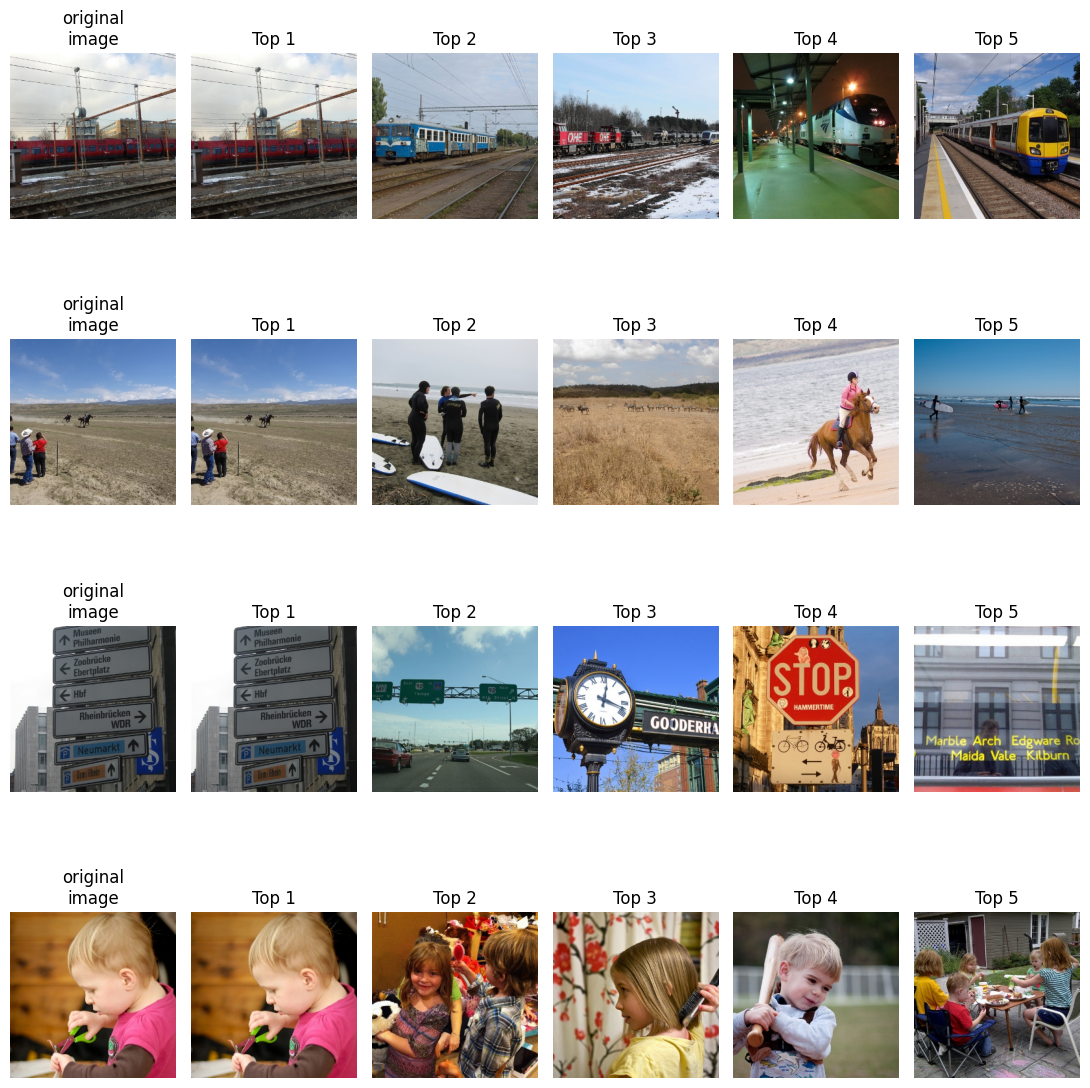

In [10]:
print("Backward retrieval")
try:
    bwd_sim = np.array(bwd_sim.cpu())
except:
    bwd_sim = np.array(bwd_sim)
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(11,12))
for trial in range(4):
    ax[trial, 0].imshow(utils.torch_to_Image(img[trial]))
    ax[trial, 0].set_title("original\nimage")
    ax[trial, 0].axis("off")
    for attempt in range(5):
        which = np.flip(np.argsort(bwd_sim[trial]))[attempt]
        ax[trial, attempt+1].imshow(utils.torch_to_Image(img[which]))
        ax[trial, attempt+1].set_title(f"Top {attempt+1}")
        ax[trial, attempt+1].axis("off")
fig.tight_layout()
plt.show()

# Reconstruction evaluation

### Load model checkpoint

In [11]:
model_name = "prior-w-voxel2clip"

outdir = f'../train_logs/models/{model_name}/test'

ckpt_path = os.path.join(outdir, f'ckpt-best.pth')
print("ckpt_path",ckpt_path)

checkpoint = torch.load(ckpt_path, map_location=device)

# utils.plot_brainnet_ckpt(ckpt_path)

ckpt_path ../train_logs/models/prior-w-voxel2clip/test/ckpt-best.pth


### Load pretrained weights onto model

In [12]:
voxel2clip = BrainNetwork(out_dim=768)

# need folder "checkpoints" with following files
# wget https://huggingface.co/nousr/conditioned-prior/raw/main/vit-l-14/aesthetic/prior_config.json
# wget https://huggingface.co/nousr/conditioned-prior/resolve/main/vit-l-14/aesthetic/best.pth
diffusion_prior = BrainDiffusionPrior.from_pretrained(
    dict(),
    dict(
        condition_on_text_encodings=False,
        timesteps=1000,
        voxel2clip=voxel2clip,
    ),
)

diffusion_prior.load_state_dict(checkpoint['model_state_dict'])
diffusion_prior.eval().to(device)
print("loaded")

loaded


### Prep data loader

In [20]:
batch_size = 4

image_var = 'images'

train_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/train/train_subj01_{0..49}.tar"
val_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/val/val_subj01_0.tar"
meta_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/metadata_subj01.json"

voxels_key = 'nsdgeneral.npy' # 1d inputs
# voxels_key = 'wholebrain_3d.npy' #3d inputs

try:
    train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
        batch_size, image_var,
        num_devices=num_devices,
        num_workers=num_workers,
        train_url=train_url,
        val_url=val_url,
        meta_url=meta_url,
        num_val_samples=4, # should be None!
#         seed=seed,
        voxels_key=voxels_key,
    )
except: # assuming error because urls were not valid
    print("Pulling data directly from huggingface...\n")
    train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
        batch_size, image_var,
        num_devices=num_devices,
        num_workers=num_workers,
        train_url=None,
        val_url=None,
        meta_url=None,
#         seed=seed,
        voxels_key=voxels_key,
    )

# check that your data loader is working
for val_i, (voxel, img_input, key) in enumerate(val_dl):
    print("idx",val_i)
    print("voxel.shape",voxel.shape)
    print("img_input.shape",img_input.shape)
    print("key[:2]",key[:2])
    break

Pulling data directly from huggingface...

Getting dataloaders...
train_url https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/9947586218b6b7c8cab804009ddca5045249a38d/webdataset/train/train_subj01_{0..49}.tar
val_url https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/9947586218b6b7c8cab804009ddca5045249a38d/webdataset/val/val_subj01_0.tar
num_devices 8
num_workers 8
batch_size 4
val_batch_size 4
global_batch_size 32
num_worker_batches 97
num_train 24983
num_val 492
cache_dir /tmp/wds-cache
validation: num_worker_batches 123


/fsx/nev/venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


.: directory
idx 0
voxel.shape torch.Size([4, 15724])
img_input.shape torch.Size([4, 3, 256, 256])
key[:2] ['sample00002', 'sample00013']


### Load SD variations model

In [14]:
from diffusers import AutoencoderKL, PNDMScheduler, UNet2DConditionModel, UniPCMultistepScheduler

#sd_cache_dir = '/fsx/home-paulscotti/.cache/huggingface/diffusers/models--lambdalabs--sd-image-variations-diffusers/snapshots/a2a13984e57db80adcc9e3f85d568dcccb9b29fc'
sd_cache_dir = '/scratch/gpfs/ps6938/nsd/stable_recons/models/sd-image-variations-diffusers/snapshots/fffa9500babf6ab7dfdde36a35ccef6d814ae432'
if not os.path.isdir(sd_cache_dir): # download from huggingface if not already downloaded / cached
    from diffusers import StableDiffusionImageVariationPipeline
    print("Downloading lambdalabs/sd-image-variations-diffusers from huggingface...")
    sd_pipe = StableDiffusionImageVariationPipeline.from_pretrained("lambdalabs/sd-image-variations-diffusers", revision="v2.0")
    sd_cache_dir = "lambdalabs/sd-image-variations-diffusers"

unet = UNet2DConditionModel.from_pretrained(sd_cache_dir,subfolder="unet").to(device)
vae = AutoencoderKL.from_pretrained(sd_cache_dir,subfolder="vae").to(device)
noise_scheduler = PNDMScheduler.from_pretrained(sd_cache_dir, subfolder="scheduler")
noise_scheduler = UniPCMultistepScheduler.from_config(noise_scheduler.config)

unet.eval() # dont want to train model
unet.requires_grad_(False) # dont need to calculate gradients

vae.eval()
vae.requires_grad_(False)
print("loaded")

Fetching 11 files: 100%|██████████| 11/11 [00:00<00:00, 9390.87it/s]


loaded


## Reconstruction via diffusion, one at a time
This will take awhile!!

2023-03-11 01:14:08
all_brain_recons.shape torch.Size([1, 16, 3, 512, 512])
all_clip_recons.shape torch.Size([4, 1, 3, 512, 512])
all_images.shape torch.Size([300, 3, 256, 256])
2023-03-11 01:14:50


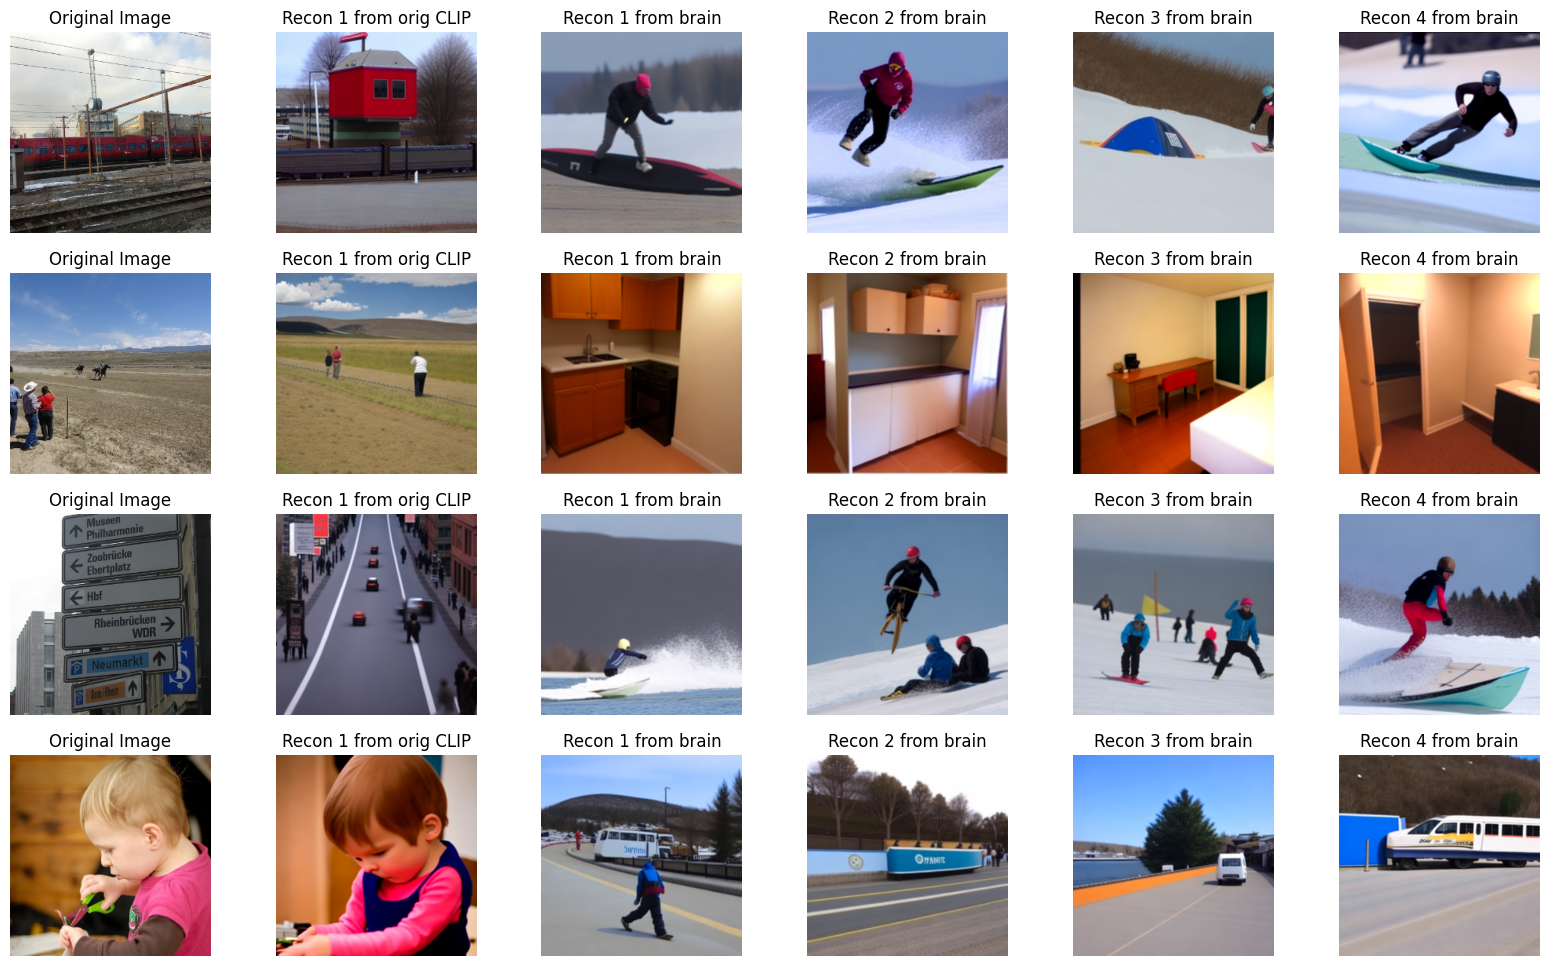

In [15]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
all_images = None
all_clip_recons = None
all_brain_recons = None
recons_per_clip = 1
recons_per_brain = 4
# for val_i, (voxel, img, trial) in enumerate(val_dl):
with torch.no_grad():
    with torch.cuda.amp.autocast():
        grid, clip_recons, brain_recons = utils.reconstruct_from_clip(
            img, voxel,
            diffusion_prior, 
            clip_extractor, unet, vae, noise_scheduler,
            img_lowlevel = None,
            num_inference_steps = 20,
            n_samples_save = batch_size,
            recons_per_clip = recons_per_clip,
            recons_per_brain = recons_per_brain,
            guidance_scale = 7.5,
            img2img_strength = .6,
            timesteps = 1000,
            seed = seed,
            distributed = distributed,
#             plotting = True,
        )
        grid.savefig(os.path.join(outdir, f'val_recons_{val_i}_batchsize{batch_size}.png'))
        if all_brain_recons is None:
            all_brain_recons = brain_recons
            all_clip_recons = clip_recons
            all_images = img
        else:
            all_brain_recons = torch.vstack((all_brain_recons,brain_recons))
            all_clip_recons = torch.vstack((all_clip_recons,clip_recons))
            all_images = torch.vstack((all_images,img))

all_brain_recons = all_brain_recons.view(len(all_brain_recons)//recons_per_brain,-1,3,512,512)
all_clip_recons = all_clip_recons.view(len(all_clip_recons)//recons_per_clip,-1,3,512,512)

torch.save(all_brain_recons,f'{outdir}/all_brain_recons')
torch.save(all_clip_recons,f'{outdir}/all_clip_recons')
torch.save(all_images,f'{outdir}/all_images')

print("all_brain_recons.shape",all_brain_recons.shape)
print("all_clip_recons.shape",all_clip_recons.shape)
print("all_images.shape",all_images.shape)
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S')) #35 seconds

2023-03-11 01:14:52
all_brain_recons.shape torch.Size([1, 16, 3, 512, 512])
all_clip_recons.shape torch.Size([4, 1, 3, 512, 512])
all_images.shape torch.Size([300, 3, 256, 256])
2023-03-11 01:15:58


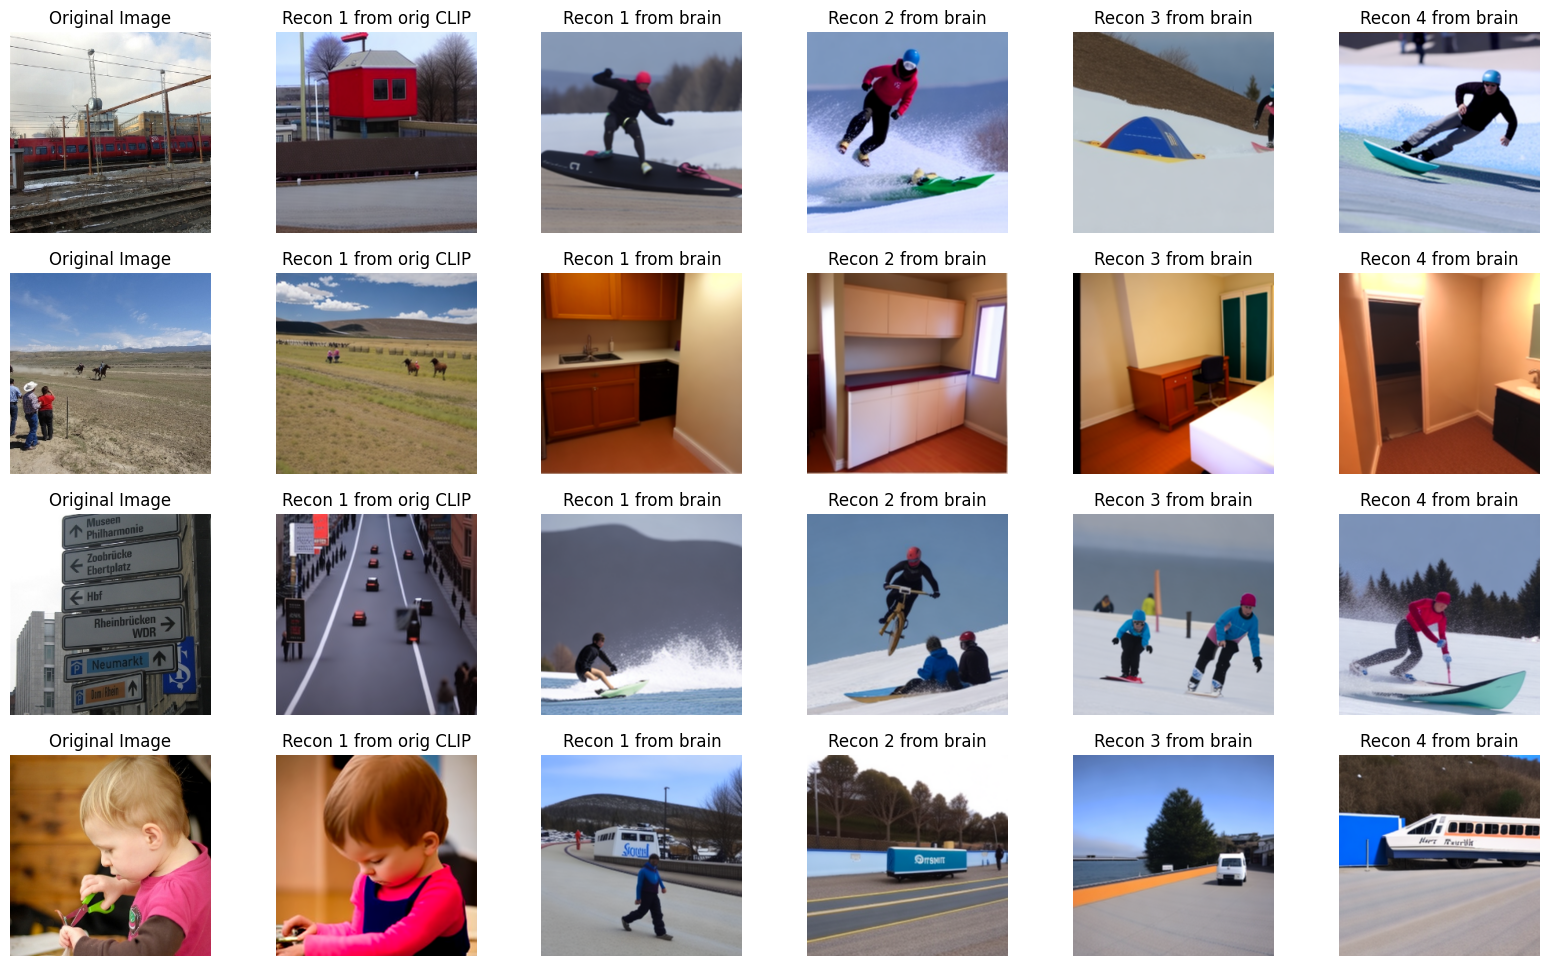

In [16]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
all_images = None
all_clip_recons = None
all_brain_recons = None
recons_per_clip = 1
recons_per_brain = 4
# for val_i, (voxel, img, trial) in enumerate(val_dl):
with torch.no_grad():
    with torch.cuda.amp.autocast():
        grid, clip_recons, brain_recons = utils.reconstruct_from_clip(
            img, voxel,
            diffusion_prior, 
            clip_extractor, unet, vae, noise_scheduler,
            img_lowlevel = None,
            num_inference_steps = 50,
            n_samples_save = batch_size,
            recons_per_clip = recons_per_clip,
            recons_per_brain = recons_per_brain,
            guidance_scale = 7.5,
            img2img_strength = .6,
            timesteps = 1000,
            seed = seed,
            distributed = distributed,
#             plotting = True,
        )
        grid.savefig(os.path.join(outdir, f'val_recons_{val_i}_batchsize{batch_size}.png'))
        if all_brain_recons is None:
            all_brain_recons = brain_recons
            all_clip_recons = clip_recons
            all_images = img
        else:
            all_brain_recons = torch.vstack((all_brain_recons,brain_recons))
            all_clip_recons = torch.vstack((all_clip_recons,clip_recons))
            all_images = torch.vstack((all_images,img))
                
all_brain_recons = all_brain_recons.view(len(all_brain_recons)//recons_per_brain,-1,3,512,512)
all_clip_recons = all_clip_recons.view(len(all_clip_recons)//recons_per_clip,-1,3,512,512)

# torch.save(all_brain_recons,f'{outdir}/all_brain_recons')
# torch.save(all_clip_recons,f'{outdir}/all_clip_recons')
# torch.save(all_images,f'{outdir}/all_images')

print("all_brain_recons.shape",all_brain_recons.shape)
print("all_clip_recons.shape",all_clip_recons.shape)
print("all_images.shape",all_images.shape)
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S')) # 70 seconds

In [26]:
import utils
import importlib
importlib.reload(utils)
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
all_images = None
all_clip_recons = None
all_brain_recons = None
recons_per_clip = 1
recons_per_brain = 4
for val_i, (voxel, img, trial) in enumerate(val_dl):
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            grid, clip_recons, brain_recons = utils.reconstruct_from_clip(
                img, voxel,
                diffusion_prior, 
                clip_extractor, unet, vae, noise_scheduler,
                img_lowlevel = None,
                num_inference_steps = 20,
                n_samples_save = batch_size,
                recons_per_clip = recons_per_clip,
                recons_per_brain = recons_per_brain,
                guidance_scale = 7.5,
                img2img_strength = .6,
                timesteps = 1000,
                seed = seed,
                distributed = distributed,
    #             plotting = True,
                retrieve=True,
            )
            grid.savefig(os.path.join(outdir, f'val_recons_{val_i}_batchsize{batch_size}.png'))
            if all_brain_recons is None:
                all_brain_recons = brain_recons
                all_clip_recons = clip_recons
                all_images = img
            else:
                all_brain_recons = torch.vstack((all_brain_recons,brain_recons))
                all_clip_recons = torch.vstack((all_clip_recons,clip_recons))
                all_images = torch.vstack((all_images,img))
#     break

all_brain_recons = all_brain_recons.view(len(all_brain_recons)//recons_per_brain,-1,3,512,512)
all_clip_recons = all_clip_recons.view(len(all_clip_recons)//recons_per_clip,-1,3,512,512)

# torch.save(all_brain_recons,f'{outdir}/all_brain_recons')
# torch.save(all_clip_recons,f'{outdir}/all_clip_recons')
# torch.save(all_images,f'{outdir}/all_images')

print("all_brain_recons.shape",all_brain_recons.shape)
print("all_clip_recons.shape",all_clip_recons.shape)
print("all_images.shape",all_images.shape)
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S')) # 36 seconds

2023-03-11 01:47:59
.: directory
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.9018704891204834}
{'url': 'https://trvimg.r10s.jp/share/image_up/104655/MIDDLE/BO9yhf.jpeg?fit=inside%7C210:210', 'caption': '雪板ライド', 'id': 4976300794, 'similarity': 0.8986972570419312}
{'url': 'https://st.hzcdn.com/simgs/2d51cb690d56df96_9-4424/home-design.jpg', 'caption': 'Chicago Bungalow Bath Remodel - BEFORE', 'id': 2551201929, 'similarity': 0.9059769511222839}
{'url': 'https://farm3.staticflickr.com/2649/4084062452_457edf08f8_z.jpg', 'caption': '1968 bathroom Flickr - Photo Sharing!', 'id': 4982845880, 'similarity': 0.9035559296607971}
{'url': 'https://propiedadescom.s3.amazonaws.com/files/detalle_ficha/zona-hotelera-benito-juarez-quintana-roo-1085277-foto-14.jpg', 'caption': 'Foto de departamento en renta en, zona hotelera, benito juárez, quintana roo, 1085277 no

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa65e0c6e50>


{'url': 'https://www.skiarealy-sjezdovky.cz/obrazky/_nova-ves-nad-nisou-nova-ves-nad-nisou-svah-wyg8.jpg', 'caption': 'Ski areál Nová Ves nad Nisou', 'id': 4046351161, 'similarity': 0.8649416565895081}
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.8620966076850891}
{'url': 'https://file1.hpage.com/010291/70/bilder/cimg4655.jpg', 'caption': 'Telemark in Kirchberg', 'id': 3835671898, 'similarity': 0.8607339262962341}
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.9016510844230652}
{'url': 'https://trvimg.r10s.jp/share/image_up/104655/MIDDLE/BO9yhf.jpeg?fit=inside%7C210:210', 'caption': '雪板ライド', 'id': 4976300794, 'similarity': 0.8983620405197144}
{'url': 'https://st.hzcdn.com/simgs/2d51cb690d56df96_9-4424/home-de

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa63fdaab80>


{'url': 'https://5929.co.uk/wp-content/gallery/spring-cruise-2018-1/thumbs/thumbs_2018-03-09-to-10-Tilbury-Antwerp.-300300.JPG', 'caption': '2018-03-09 to 10 Tilbury - Antwerp.  (300)300', 'id': 3519040543, 'similarity': 0.8494910597801208}


Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa63921f860>


{'url': 'http://s.tf1.fr/mmdia/i/52/3/sncf-greve-11187523zehit_2926.jpg?v=1', 'caption': 'SNCF grève', 'id': 4415431912, 'similarity': 0.84921795129776}
{'url': 'https://i2.wp.com/unpeucliche.com/wp-content/uploads/2018/02/Laos_Vientiane_buddha_park_bus.jpg?resize=736%2C491&ssl=1', 'caption': 'Laos - Vientiane - Buddha Park bus', 'id': 333821928, 'similarity': 0.8474350571632385}
{'url': 'https://www.bahninfo-forum.de/embed_images/8f7/6b4/895/49c/f89/90a/db4/d7c/d6f/ae1/ba_1200x920.jpg', 'caption': 'bahninfo-bus02.jpg', 'id': 830877244, 'similarity': 0.8450772166252136}
{'url': 'https://abakan.bezformata.com/content/image313120397.jpg', 'caption': 'На Красноярской магистрали начался масштабный ремонт пассажирских платформ и остановочных пунктов - ИА Агентство Деловой Информации', 'id': 5013548888, 'similarity': 0.844318687915802}
{'url': 'http://s.tf1.fr/mmdia/i/05/8/rer-train-transport-quai-10324058vpted_2987.jpg?v=1', 'caption': 'rer train transport quai', 'id': 4980933616, 'similari

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa65e414b80>


{'url': 'http://d1hw6n3yxknhky.cloudfront.net/000517705_iconv.jpeg', 'caption': 'Stock Video Footage of New York subway train departing', 'id': 2692779439, 'similarity': 0.8439030647277832}
{'url': 'https://career-delight.co.jp/wp/wp-content/uploads/2019/11/2019-11-13_02h58_32.png', 'caption': '鉄道撮影が趣味', 'id': 3927765823, 'similarity': 0.8435347676277161}


Traceback (most recent call last):
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 386, in _make_request
    self._validate_conn(conn)
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 1042, in _validate_conn
    conn.connect()
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connection.py", line 467, in connect
    _match_hostname(cert, self.assert_hostname or server_hostname)
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connection.py", line 540, in _match_hostname
    match_hostname(cert, asserted_hostname)
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/util/ssl_match_hostname.py", line 150, in match_hostname
    raise CertificateError(
urllib3.util.ssl_match_hostname.CertificateError: hostname 'career-delight.co.jp' doesn't match either of '*.c

{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.8983205556869507}
{'url': 'http://www.albergo-oswald.it/wp-content/uploads/2016/09/snowboarding-554048_1920-150x150.jpg', 'caption': 'snowboarding-554048_1920', 'id': 188036703, 'similarity': 0.8950219750404358}


Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa65e414b80>


{'url': 'https://www.atipt.com/sites/default/files/styles/sidebar_images/public/Freestyle-Skiing-%28Moguls%29-for-web_0.jpg?itok=lKXIUEd2&c=c38a832f02d60d3c6ef2a8b329c7af2e', 'caption': 'Freestyle Skiing – Keeping It Injury Free', 'id': 3705164601, 'similarity': 0.8918465375900269}
{'url': 'https://www.skiarealy-sjezdovky.cz/obrazky/_nova-ves-nad-nisou-nova-ves-nad-nisou-svah-wyg8.jpg', 'caption': 'Ski areál Nová Ves nad Nisou', 'id': 4046351161, 'similarity': 0.8916232585906982}
{'url': 'https://trvimg.r10s.jp/share/image_up/104655/MIDDLE/BO9yhf.jpeg?fit=inside%7C210:210', 'caption': '雪板ライド', 'id': 4976300794, 'similarity': 0.8912671804428101}
{'url': 'https://media-cdn.tripadvisor.com/media/photo-s/06/6a/b8/b2/giraffes.jpg', 'caption': 'Mara Serena Safari Lodge: Giraffes', 'id': 48444259, 'similarity': 0.9090085029602051}
{'url': 'https://images.saymedia-content.com/.image/t_share/MTc2NDUyNTUzMDQ2ODk0NTU0/top-10-best-must-see-disney-world-animal-kingdom-theme-park-rides-attractions-a

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa622b968b0>


{'url': 'http://www.albergo-oswald.it/wp-content/uploads/2016/09/snowboarding-554048_1920-150x150.jpg', 'caption': 'snowboarding-554048_1920', 'id': 188036703, 'similarity': 0.8887632489204407}


Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa6391c5ef0>


{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.8885514736175537}
{'url': 'https://www.skiarealy-sjezdovky.cz/obrazky/_nova-ves-nad-nisou-nova-ves-nad-nisou-svah-wyg8.jpg', 'caption': 'Ski areál Nová Ves nad Nisou', 'id': 4046351161, 'similarity': 0.8857210874557495}
{'url': 'https://file1.hpage.com/010291/70/bilder/cimg4655.jpg', 'caption': 'Telemark in Kirchberg', 'id': 3835671898, 'similarity': 0.8823260068893433}
{'url': 'http://s.tf1.fr/mmdia/i/52/3/sncf-greve-11187523zehit_2926.jpg?v=1', 'caption': 'SNCF grève', 'id': 4415431912, 'similarity': 0.8516141176223755}
{'url': 'https://5929.co.uk/wp-content/gallery/spring-cruise-2018-1/thumbs/thumbs_2018-03-09-to-10-Tilbury-Antwerp.-300300.JPG', 'caption': '2018-03-09 to 10 Tilbury - Antwerp.  (300)300', 'id': 3519040543, 'similarity': 0.851291835308075}


Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa65f670db0>


{'url': 'https://www.bahninfo-forum.de/embed_images/8f7/6b4/895/49c/f89/90a/db4/d7c/d6f/ae1/ba_1200x920.jpg', 'caption': 'bahninfo-bus02.jpg', 'id': 830877244, 'similarity': 0.8477293252944946}
{'url': 'https://i2.wp.com/unpeucliche.com/wp-content/uploads/2018/02/Laos_Vientiane_buddha_park_bus.jpg?resize=736%2C491&ssl=1', 'caption': 'Laos - Vientiane - Buddha Park bus', 'id': 333821928, 'similarity': 0.8477257490158081}
{'url': 'https://career-delight.co.jp/wp/wp-content/uploads/2019/11/2019-11-13_02h58_32.png', 'caption': '鉄道撮影が趣味', 'id': 3927765823, 'similarity': 0.8470099568367004}


Traceback (most recent call last):
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 386, in _make_request
    self._validate_conn(conn)
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 1042, in _validate_conn
    conn.connect()
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connection.py", line 467, in connect
    _match_hostname(cert, self.assert_hostname or server_hostname)
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connection.py", line 540, in _match_hostname
    match_hostname(cert, asserted_hostname)
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/util/ssl_match_hostname.py", line 150, in match_hostname
    raise CertificateError(
urllib3.util.ssl_match_hostname.CertificateError: hostname 'career-delight.co.jp' doesn't match either of '*.c

{'url': 'https://abakan.bezformata.com/content/image313120397.jpg', 'caption': 'На Красноярской магистрали начался масштабный ремонт пассажирских платформ и остановочных пунктов - ИА Агентство Деловой Информации', 'id': 5013548888, 'similarity': 0.8468500375747681}
{'url': 'http://s.tf1.fr/mmdia/i/05/8/rer-train-transport-quai-10324058vpted_2987.jpg?v=1', 'caption': 'rer train transport quai', 'id': 4980933616, 'similarity': 0.8467698693275452}
{'url': 'http://d1hw6n3yxknhky.cloudfront.net/000517705_iconv.jpeg', 'caption': 'Stock Video Footage of New York subway train departing', 'id': 2692779439, 'similarity': 0.8460777401924133}
{'url': 'https://i0.wp.com/www.scenictrailventures.com/wp-content/uploads/2018/07/lake-mburo-safari8.jpg?fit=1024%2C683&amp;ssl=1', 'caption': 'Lake Mburo National Park giraffe', 'id': 908362704, 'similarity': 0.9133466482162476}
{'url': 'http://s.tf1.fr/mmdia/i/52/3/sncf-greve-11187523zehit_2926.jpg?v=1', 'caption': 'SNCF grève', 'id': 4415431912, 'similarit

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa63f4d4cc0>


{'url': 'https://i2.wp.com/unpeucliche.com/wp-content/uploads/2018/02/Laos_Vientiane_buddha_park_bus.jpg?resize=736%2C491&ssl=1', 'caption': 'Laos - Vientiane - Buddha Park bus', 'id': 333821928, 'similarity': 0.8389827013015747}
{'url': 'http://blog-imgs-73.fc2.com/t/a/i/taipeiroc/P1120778_convert_20150207120839s.jpg', 'caption': 'バスで高雄に帰る150206', 'id': 4760656790, 'similarity': 0.8381673693656921}
{'url': 'https://citytraffic.ru/wp-content/uploads/2019/10/1543575069.jpg', 'caption': 'Жители Самары требуют вернуть большие автобусы', 'id': 4207587821, 'similarity': 0.8360095024108887}
{'url': 'https://abakan.bezformata.com/content/image313120397.jpg', 'caption': 'На Красноярской магистрали начался масштабный ремонт пассажирских платформ и остановочных пунктов - ИА Агентство Деловой Информации', 'id': 5013548888, 'similarity': 0.8355464935302734}
{'url': 'https://career-delight.co.jp/wp/wp-content/uploads/2019/11/2019-11-13_02h58_32.png', 'caption': '鉄道撮影が趣味', 'id': 3927765823, 'similar

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa63f4d4cc0>
Traceback (most recent call last):
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 386, in _make_request
    self._validate_conn(conn)
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 1042, in _validate_conn
    conn.connect()
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connection.py", line 467, in connect
    _match_hostname(cert, self.assert_hostname or server_hostname)
  File "/fsx/nev/venv/lib/python3.8/site-packages/url

{'url': 'https://d3h1q508sbh4k1.cloudfront.net/sisustus/wp-content/uploads/2015/08/kuva6-e1510831059714.jpg', 'caption': 'Keittiöremontin lähtötilanne', 'id': 5080360662, 'similarity': 0.8698024749755859}
{'url': 'http://1.bp.blogspot.com/-xIu-cqmHhks/UGeVnVmW20I/AAAAAAAABw0/7oafxbRmVKc/s1600/100_5033.JPG', 'caption': 'Open Up Kitchen', 'id': 5070517305, 'similarity': 0.8671337962150574}
{'url': 'https://img.u.travel/?id=112258&img=153277963.jpg&travel=1', 'caption': 'Sunny Holiday Apartments, фото 14', 'id': 4918549909, 'similarity': 0.8669952154159546}
{'url': 'https://designpress.com/wp-content/uploads/2012/09/kitchen-countertop-ideas/new-type-of-kitchen.jpg', 'caption': 'Stylish Kitchen', 'id': 5047125380, 'similarity': 0.8669143319129944}
{'url': 'https://p4.storage.canalblog.com/48/65/239999/12590582.jpg', 'caption': 'ma petite cuisine en photo coups 2 coeurs cuisine lecture et d co au quotidien. Black Bedroom Furniture Sets. Home Design Ideas', 'id': 3594929521, 'similarity': 0.

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa63f4d4cc0>


{'url': 'https://st.hzcdn.com/simgs/2d51cb690d56df96_9-4424/home-design.jpg', 'caption': 'Chicago Bungalow Bath Remodel - BEFORE', 'id': 2551201929, 'similarity': 0.9053569436073303}
{'url': 'https://farm3.staticflickr.com/2649/4084062452_457edf08f8_z.jpg', 'caption': '1968 bathroom Flickr - Photo Sharing!', 'id': 4982845880, 'similarity': 0.9037038683891296}
{'url': 'https://simplychicforcheap.files.wordpress.com/2013/09/012.jpg?w=500&', 'caption': 'small bathroom', 'id': 2475756371, 'similarity': 0.9031378030776978}
{'url': 'https://propiedadescom.s3.amazonaws.com/files/detalle_ficha/zona-hotelera-benito-juarez-quintana-roo-1085277-foto-14.jpg', 'caption': 'Foto de departamento en renta en, zona hotelera, benito juárez, quintana roo, 1085277 no 14', 'id': 4997868045, 'similarity': 0.9023067355155945}
{'url': 'https://cdn-fastly.hometalk.com/media/2017/09/25/4292726/50-dollar-bathroom-makeover.jpg?size=786x922&amp;nocrop=1', 'caption': '50 dollar bathroom makeover', 'id': 563738508, '

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa65f5098b0>


{'url': 'https://www.skiarealy-sjezdovky.cz/obrazky/_nova-ves-nad-nisou-nova-ves-nad-nisou-svah-wyg8.jpg', 'caption': 'Ski areál Nová Ves nad Nisou', 'id': 4046351161, 'similarity': 0.8825834393501282}
{'url': 'https://file1.hpage.com/010291/70/bilder/cimg4655.jpg', 'caption': 'Telemark in Kirchberg', 'id': 3835671898, 'similarity': 0.8781652450561523}
{'url': 'https://noasc.com/media/k2/items/cache/ce7646a74c54cecf1c05442c71f02147_L.jpg', 'caption': 'NOASC Niseko Snowboard Lesson Level 4', 'id': 2712570047, 'similarity': 0.8765706419944763}
{'url': 'https://i0.wp.com/www.scenictrailventures.com/wp-content/uploads/2018/07/lake-mburo-safari8.jpg?fit=1024%2C683&amp;ssl=1', 'caption': 'Lake Mburo National Park giraffe', 'id': 908362704, 'similarity': 0.9132512807846069}
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.9022449851036072}
{'url': 'https://

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa66e111540>


{'url': 'https://citytraffic.ru/wp-content/uploads/2019/10/1543575069.jpg', 'caption': 'Жители Самары требуют вернуть большие автобусы', 'id': 4207587821, 'similarity': 0.8366555571556091}
{'url': 'http://view.web-stage.nl/userfiles/cache/wwwradeklegalnl/badkamers_en_toiletten/badkamers_en_toiletten_plaatsen-0028_w_155_h_155_q_100.jpg', 'caption': 'Badkamers En Toiletten Plaatsen 0028', 'id': 5351305070, 'similarity': 0.8364675641059875}
{'url': 'https://bricoleurpro.ouest-france.fr/images/dossiers/2021-02/mini/hauteur-miroir-salle-de-bain-164224-310-160.jpg', 'caption': 'A quelle hauteur placer son miroir de salle de bain ?', 'id': 1073954594, 'similarity': 0.8354969620704651}
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.9017553925514221}
{'url': 'https://trvimg.r10s.jp/share/image_up/104655/MIDDLE/BO9yhf.jpeg?fit=inside%7C210:210', 'caption': '

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa63f249c20>


{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.8797638416290283}
{'url': 'https://www.skiarealy-sjezdovky.cz/obrazky/_nova-ves-nad-nisou-nova-ves-nad-nisou-svah-wyg8.jpg', 'caption': 'Ski areál Nová Ves nad Nisou', 'id': 4046351161, 'similarity': 0.879314124584198}
{'url': 'https://file1.hpage.com/010291/70/bilder/cimg4655.jpg', 'caption': 'Telemark in Kirchberg', 'id': 3835671898, 'similarity': 0.8756621479988098}
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.8980663418769836}
{'url': 'https://www.zibashahr.com/wp-content/uploads/2016/01/dizin6.jpg', 'caption': 'زنان ایرانی در پیست اسکی دیزین', 'id': 4151924338, 'similarity': 0.8944987058639526}
{'url': 'https://trvimg.r10s.jp/share/image_up/104655/MIDDLE/BO9

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa63ea6a4f0>


{'url': 'https://software.realgest.it/images/get/800x600/5a0c584ee3310.jpg', 'caption': 'bagno piccolo.jpg', 'id': 4648858324, 'similarity': 0.885899543762207}
{'url': 'https://i0.wp.com/www.scenictrailventures.com/wp-content/uploads/2018/07/lake-mburo-safari8.jpg?fit=1024%2C683&amp;ssl=1', 'caption': 'Lake Mburo National Park giraffe', 'id': 908362704, 'similarity': 0.9133260250091553}
{'url': 'http://s.tf1.fr/mmdia/i/52/3/sncf-greve-11187523zehit_2926.jpg?v=1', 'caption': 'SNCF grève', 'id': 4415431912, 'similarity': 0.8555376529693604}
{'url': 'https://5929.co.uk/wp-content/gallery/spring-cruise-2018-1/thumbs/thumbs_2018-03-09-to-10-Tilbury-Antwerp.-300300.JPG', 'caption': '2018-03-09 to 10 Tilbury - Antwerp.  (300)300', 'id': 3519040543, 'similarity': 0.8531738519668579}


Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa63eab4590>


{'url': 'https://career-delight.co.jp/wp/wp-content/uploads/2019/11/2019-11-13_02h58_32.png', 'caption': '鉄道撮影が趣味', 'id': 3927765823, 'similarity': 0.8521049618721008}


Traceback (most recent call last):
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 386, in _make_request
    self._validate_conn(conn)
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 1042, in _validate_conn
    conn.connect()
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connection.py", line 467, in connect
    _match_hostname(cert, self.assert_hostname or server_hostname)
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connection.py", line 540, in _match_hostname
    match_hostname(cert, asserted_hostname)
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/util/ssl_match_hostname.py", line 150, in match_hostname
    raise CertificateError(
urllib3.util.ssl_match_hostname.CertificateError: hostname 'career-delight.co.jp' doesn't match either of '*.c

{'url': 'https://abakan.bezformata.com/content/image313120397.jpg', 'caption': 'На Красноярской магистрали начался масштабный ремонт пассажирских платформ и остановочных пунктов - ИА Агентство Деловой Информации', 'id': 5013548888, 'similarity': 0.8504518270492554}
{'url': 'https://www.bahninfo-forum.de/embed_images/8f7/6b4/895/49c/f89/90a/db4/d7c/d6f/ae1/ba_1200x920.jpg', 'caption': 'bahninfo-bus02.jpg', 'id': 830877244, 'similarity': 0.8503704071044922}
{'url': 'https://perm.bezformata.com/content/image331571355.jpg', 'caption': 'В городском call-центре прошла прямая линия по вопросам пассажирских перевозок в пермских электричках - Администрация города Перми', 'id': 5226889801, 'similarity': 0.8495773673057556}
{'url': 'http://s.tf1.fr/mmdia/i/05/8/rer-train-transport-quai-10324058vpted_2987.jpg?v=1', 'caption': 'rer train transport quai', 'id': 4980933616, 'similarity': 0.8490410447120667}


Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa63eab4590>


{'url': 'http://tripedia.info/wp-content/uploads/2015/01/The-Black-Forest-Railway-215x140.jpg', 'caption': 'The-Black-Forest-Railway', 'id': 2603200470, 'similarity': 0.8490212559700012}


Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa65f35c5e0>


{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.9018514752388}
{'url': 'https://trvimg.r10s.jp/share/image_up/104655/MIDDLE/BO9yhf.jpeg?fit=inside%7C210:210', 'caption': '雪板ライド', 'id': 4976300794, 'similarity': 0.8985477089881897}
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.9018838405609131}
{'url': 'https://trvimg.r10s.jp/share/image_up/104655/MIDDLE/BO9yhf.jpeg?fit=inside%7C210:210', 'caption': '雪板ライド', 'id': 4976300794, 'similarity': 0.8985245823860168}
{'url': 'http://view.web-stage.nl/userfiles/cache/wwwradeklegalnl/badkamers_en_toiletten/badkamers_en_toiletten_plaatsen-0028_w_155_h_155_q_100.jpg', 'caption': 'Badkamers En Toiletten Plaatsen 0028', 'id': 5351305070, 'similarity': 0.842384934425354}
{'url

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa6220dad60>


{'url': 'https://media-cdn.tripadvisor.com/media/vr-splice-j/00/aa/5e/c9.jpg', 'caption': 'Baño principal', 'id': 958546088, 'similarity': 0.835162878036499}
{'url': 'https://i0.wp.com/www.scenictrailventures.com/wp-content/uploads/2018/07/lake-mburo-safari8.jpg?fit=1024%2C683&amp;ssl=1', 'caption': 'Lake Mburo National Park giraffe', 'id': 908362704, 'similarity': 0.913324236869812}
{'url': 'https://d3h1q508sbh4k1.cloudfront.net/sisustus/wp-content/uploads/2015/08/kuva6-e1510831059714.jpg', 'caption': 'Keittiöremontin lähtötilanne', 'id': 5080360662, 'similarity': 0.8718541860580444}
{'url': 'http://1.bp.blogspot.com/-xIu-cqmHhks/UGeVnVmW20I/AAAAAAAABw0/7oafxbRmVKc/s1600/100_5033.JPG', 'caption': 'Open Up Kitchen', 'id': 5070517305, 'similarity': 0.8710474371910095}
{'url': 'http://v.poliris.com/s/width/800/visuels/1/c/j/3/1cj3wpg8s33b8jzuvt1l9fegnli7rmpb0j69vyljg.jpg', 'caption': 'Sale apartment Saint-michel-sur-orge 161000€ - Picture 3', 'id': 4805337681, 'similarity': 0.87026762962

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa5bf96d5e0>


{'url': 'https://st.hzcdn.com/simgs/2d51cb690d56df96_9-4424/home-design.jpg', 'caption': 'Chicago Bungalow Bath Remodel - BEFORE', 'id': 2551201929, 'similarity': 0.885696530342102}
{'url': 'http://v.poliris.com/s/width/800/visuels/1/c/j/3/1cj3wpg8s33b8jzuvt1l9fegnli7rmpb0j69vyljg.jpg', 'caption': 'Sale apartment Saint-michel-sur-orge 161000€ - Picture 3', 'id': 4805337681, 'similarity': 0.8841611742973328}
{'url': 'http://1.bp.blogspot.com/-xIu-cqmHhks/UGeVnVmW20I/AAAAAAAABw0/7oafxbRmVKc/s1600/100_5033.JPG', 'caption': 'Open Up Kitchen', 'id': 5070517305, 'similarity': 0.8817225098609924}
{'url': 'https://assets.adaptimmo.com/photos-biens/34149/3414919038_15.jpg?fit=max&h=190&mark=34155..%2Fimages%2FAutoMergeBien-210x190.png&markpos=bottom-right&q=90&w=210&s=147305b904e7f88ef5e4fddc4b37017b', 'caption': "En location saisonnière Marseillan Plage 3414919038 S'antoni immobilier grau d'agde", 'id': 5314857868, 'similarity': 0.88023442029953}
{'url': 'https://p4.storage.canalblog.com/48/65

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa5be9d8ea0>


{'url': 'https://st.hzcdn.com/simgs/2d51cb690d56df96_9-4424/home-design.jpg', 'caption': 'Chicago Bungalow Bath Remodel - BEFORE', 'id': 2551201929, 'similarity': 0.9049650430679321}
{'url': 'https://farm3.staticflickr.com/2649/4084062452_457edf08f8_z.jpg', 'caption': '1968 bathroom Flickr - Photo Sharing!', 'id': 4982845880, 'similarity': 0.9010578989982605}
{'url': 'http://v.seloger.com/s/height/800/visuels/1/d/o/z/1doztxaefb415knrdsfijm9u3m7tzh59sb5zgdajv.jpg', 'caption': 'Vente appartement Les sables d olonne 119000€ - Photo 4', 'id': 5343885700, 'similarity': 0.9007927775382996}
{'url': 'https://propiedadescom.s3.amazonaws.com/files/detalle_ficha/zona-hotelera-benito-juarez-quintana-roo-1085277-foto-14.jpg', 'caption': 'Foto de departamento en renta en, zona hotelera, benito juárez, quintana roo, 1085277 no 14', 'id': 4997868045, 'similarity': 0.9007073640823364}
{'url': 'https://img.rentberry.com/QVcwy25xMAnz4O3R3YCCu0NOcxeC3bmmaHjUkms8L10/auto/440/440/sm/1/plain/media/apartments

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa5be981bd0>


{'url': 'https://www.skiarealy-sjezdovky.cz/obrazky/_nova-ves-nad-nisou-nova-ves-nad-nisou-svah-wyg8.jpg', 'caption': 'Ski areál Nová Ves nad Nisou', 'id': 4046351161, 'similarity': 0.8745768666267395}
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.8743783831596375}
{'url': 'https://file1.hpage.com/010291/70/bilder/cimg4655.jpg', 'caption': 'Telemark in Kirchberg', 'id': 3835671898, 'similarity': 0.8699417114257812}
{'url': 'https://noasc.com/media/k2/items/cache/ce7646a74c54cecf1c05442c71f02147_L.jpg', 'caption': 'NOASC Niseko Snowboard Lesson Level 4', 'id': 2712570047, 'similarity': 0.8679967522621155}
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.9021153450012207}
{'url': 'https://trvimg.r10s.jp/share/imag

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa5be23ac20>


{'url': 'https://d3h1q508sbh4k1.cloudfront.net/sisustus/wp-content/uploads/2015/08/kuva6-e1510831059714.jpg', 'caption': 'Keittiöremontin lähtötilanne', 'id': 5080360662, 'similarity': 0.870176374912262}
{'url': 'http://1.bp.blogspot.com/-xIu-cqmHhks/UGeVnVmW20I/AAAAAAAABw0/7oafxbRmVKc/s1600/100_5033.JPG', 'caption': 'Open Up Kitchen', 'id': 5070517305, 'similarity': 0.8683823347091675}
{'url': 'https://designpress.com/wp-content/uploads/2012/09/kitchen-countertop-ideas/new-type-of-kitchen.jpg', 'caption': 'Stylish Kitchen', 'id': 5047125380, 'similarity': 0.8675373196601868}
{'url': 'https://img.u.travel/?id=112258&img=153277963.jpg&travel=1', 'caption': 'Sunny Holiday Apartments, фото 14', 'id': 4918549909, 'similarity': 0.8673149347305298}
{'url': 'http://v.poliris.com/s/width/800/visuels/1/c/j/3/1cj3wpg8s33b8jzuvt1l9fegnli7rmpb0j69vyljg.jpg', 'caption': 'Sale apartment Saint-michel-sur-orge 161000€ - Picture 3', 'id': 4805337681, 'similarity': 0.8671415448188782}
{'url': 'https://p

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa5be23a3b0>


{'url': 'http://s.tf1.fr/mmdia/i/52/3/sncf-greve-11187523zehit_2926.jpg?v=1', 'caption': 'SNCF grève', 'id': 4415431912, 'similarity': 0.8335890769958496}
{'url': 'http://www.albergo-oswald.it/wp-content/uploads/2016/09/snowboarding-554048_1920-150x150.jpg', 'caption': 'snowboarding-554048_1920', 'id': 188036703, 'similarity': 0.8317456245422363}


Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa5bf1430e0>


{'url': 'https://www.skiarealy-sjezdovky.cz/obrazky/_nova-ves-nad-nisou-nova-ves-nad-nisou-svah-wyg8.jpg', 'caption': 'Ski areál Nová Ves nad Nisou', 'id': 4046351161, 'similarity': 0.8297916054725647}
{'url': 'http://img.odessa1.com/images/news/154x86/g-2-89942-1.jpg', 'caption': 'Кроме Украинский автобус перевернулся в Австрии можно так же прочитать Целитель изменит движение маршруток', 'id': 4709775070, 'similarity': 0.8273620009422302}
{'url': 'https://www.oldenburger-onlinezeitung.de/wp-content/uploads/2020/04/dts_image_4923_gjeigognpi_344_750_524.jpg', 'caption': 'Straßenbahnhaltestelle, über dts Nachrichtenagentur', 'id': 4889404913, 'similarity': 0.8266634941101074}
{'url': 'https://5929.co.uk/wp-content/gallery/spring-cruise-2018-1/thumbs/thumbs_2018-03-09-to-10-Tilbury-Antwerp.-300300.JPG', 'caption': '2018-03-09 to 10 Tilbury - Antwerp.  (300)300', 'id': 3519040543, 'similarity': 0.8264379501342773}


Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa5bf9575e0>


{'url': 'https://www.skiarealy-sjezdovky.cz/obrazky/_x-park-frantiskov-frantiskov-kotva-b2vu.jpg', 'caption': 'Ski areál X-park Františkov', 'id': 5267432542, 'similarity': 0.825605034828186}
{'url': 'https://www.seechat.de/photopost/data/906/thumbs/Skimax-Perfect-Sunday-Warth-Schroecken-230110-Bodensee-Community-seechat_de-IMG_8239.JPG', 'caption': 'Skimax-Perfect-Sunday-Warth-Schroecken-230110-Bodensee-Community-seechat_de-IMG_8239.JPG', 'id': 3934960748, 'similarity': 0.8255698680877686}
{'url': 'http://s.tf1.fr/mmdia/i/52/3/sncf-greve-11187523zehit_2926.jpg?v=1', 'caption': 'SNCF grève', 'id': 4415431912, 'similarity': 0.8416099548339844}
{'url': 'https://career-delight.co.jp/wp/wp-content/uploads/2019/11/2019-11-13_02h58_32.png', 'caption': '鉄道撮影が趣味', 'id': 3927765823, 'similarity': 0.8351837396621704}


Traceback (most recent call last):
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 386, in _make_request
    self._validate_conn(conn)
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 1042, in _validate_conn
    conn.connect()
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connection.py", line 467, in connect
    _match_hostname(cert, self.assert_hostname or server_hostname)
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connection.py", line 540, in _match_hostname
    match_hostname(cert, asserted_hostname)
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/util/ssl_match_hostname.py", line 150, in match_hostname
    raise CertificateError(
urllib3.util.ssl_match_hostname.CertificateError: hostname 'career-delight.co.jp' doesn't match either of '*.c

{'url': 'https://www.oldenburger-onlinezeitung.de/wp-content/uploads/2020/04/dts_image_4923_gjeigognpi_344_750_524.jpg', 'caption': 'Straßenbahnhaltestelle, über dts Nachrichtenagentur', 'id': 4889404913, 'similarity': 0.8346502184867859}
{'url': 'https://5929.co.uk/wp-content/gallery/spring-cruise-2018-1/thumbs/thumbs_2018-03-09-to-10-Tilbury-Antwerp.-300300.JPG', 'caption': '2018-03-09 to 10 Tilbury - Antwerp.  (300)300', 'id': 3519040543, 'similarity': 0.8340634107589722}


Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa5bf9575e0>
Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa5be6d94a0>


{'url': 'https://abakan.bezformata.com/content/image313120397.jpg', 'caption': 'На Красноярской магистрали начался масштабный ремонт пассажирских платформ и остановочных пунктов - ИА Агентство Деловой Информации', 'id': 5013548888, 'similarity': 0.8322799205780029}
{'url': 'http://img.odessa1.com/images/news/154x86/g-2-89942-1.jpg', 'caption': 'Кроме Украинский автобус перевернулся в Австрии можно так же прочитать Целитель изменит движение маршруток', 'id': 4709775070, 'similarity': 0.8322753310203552}
{'url': 'https://farm9.staticflickr.com/8568/16566156069_fdd2267041_c.jpg', 'caption': '都電荒川線フォトウォーク 2015年3月8日', 'id': 5397389161, 'similarity': 0.8314468860626221}
{'url': 'https://i-df.unimedias.fr/2011/03/02/loisirs-voyages30v.jpg?auto=format%2Ccompress&crop=faces&cs=tinysrgb&fit=crop&h=800&w=800', 'caption': "Tarifs SNCF : comment s'y retrouver ?", 'id': 4815614687, 'similarity': 0.8307437896728516}
{'url': 'https://i0.wp.com/www.scenictrailventures.com/wp-content/uploads/2018/07/lak

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa5588b8450>


{'url': 'https://www.skiarealy-sjezdovky.cz/obrazky/_nova-ves-nad-nisou-nova-ves-nad-nisou-svah-wyg8.jpg', 'caption': 'Ski areál Nová Ves nad Nisou', 'id': 4046351161, 'similarity': 0.8885964155197144}
{'url': 'https://file1.hpage.com/010291/70/bilder/cimg4655.jpg', 'caption': 'Telemark in Kirchberg', 'id': 3835671898, 'similarity': 0.8853139877319336}
{'url': 'https://www.luisa-thilo.de/wp-content/uploads/2013/03/DSC_0088_V02.jpg', 'caption': 'Januar 2008 - Luisa auf dem Snowboard, noch ohne Helm.', 'id': 4849029748, 'similarity': 0.8845997452735901}
{'url': 'https://i0.wp.com/www.scenictrailventures.com/wp-content/uploads/2018/07/lake-mburo-safari8.jpg?fit=1024%2C683&amp;ssl=1', 'caption': 'Lake Mburo National Park giraffe', 'id': 908362704, 'similarity': 0.9132830500602722}
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.9019564986228943}
{'url':

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa54f8c6720>


{'url': 'https://i0.wp.com/www.scenictrailventures.com/wp-content/uploads/2018/07/lake-mburo-safari8.jpg?fit=1024%2C683&amp;ssl=1', 'caption': 'Lake Mburo National Park giraffe', 'id': 908362704, 'similarity': 0.913223147392273}
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.9018474817276001}
{'url': 'https://trvimg.r10s.jp/share/image_up/104655/MIDDLE/BO9yhf.jpeg?fit=inside%7C210:210', 'caption': '雪板ライド', 'id': 4976300794, 'similarity': 0.8985754251480103}
{'url': 'https://media-cdn.tripadvisor.com/media/photo-s/06/6a/b8/b2/giraffes.jpg', 'caption': 'Mara Serena Safari Lodge: Giraffes', 'id': 48444259, 'similarity': 0.9131718873977661}
{'url': 'http://view.web-stage.nl/userfiles/cache/wwwradeklegalnl/badkamers_en_toiletten/badkamers_en_toiletten_plaatsen-0028_w_155_h_155_q_100.jpg', 'caption': 'Badkamers En Toiletten Plaatsen 0028', 'id': 53513050

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa5591e93b0>


{'url': 'http://blog-imgs-73.fc2.com/t/a/i/taipeiroc/P1120778_convert_20150207120839s.jpg', 'caption': 'バスで高雄に帰る150206', 'id': 4760656790, 'similarity': 0.8345374464988708}
{'url': 'https://i2.wp.com/unpeucliche.com/wp-content/uploads/2018/02/Laos_Vientiane_buddha_park_bus.jpg?resize=736%2C491&ssl=1', 'caption': 'Laos - Vientiane - Buddha Park bus', 'id': 333821928, 'similarity': 0.8342593312263489}
{'url': 'http://img.odessa1.com/images/news/154x86/g-2-89942-1.jpg', 'caption': 'Кроме Украинский автобус перевернулся в Австрии можно так же прочитать Целитель изменит движение маршруток', 'id': 4709775070, 'similarity': 0.832125723361969}
{'url': 'https://citytraffic.ru/wp-content/uploads/2019/10/1543575069.jpg', 'caption': 'Жители Самары требуют вернуть большие автобусы', 'id': 4207587821, 'similarity': 0.8317615985870361}
{'url': 'http://view.web-stage.nl/userfiles/cache/wwwradeklegalnl/badkamers_en_toiletten/badkamers_en_toiletten_plaatsen-0028_w_155_h_155_q_100.jpg', 'caption': 'Badka

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa54f9e38b0>


{'url': 'https://st.hzcdn.com/simgs/2d51cb690d56df96_9-4424/home-design.jpg', 'caption': 'Chicago Bungalow Bath Remodel - BEFORE', 'id': 2551201929, 'similarity': 0.8987933397293091}
{'url': 'http://v.seloger.com/s/height/800/visuels/1/d/o/z/1doztxaefb415knrdsfijm9u3m7tzh59sb5zgdajv.jpg', 'caption': 'Vente appartement Les sables d olonne 119000€ - Photo 4', 'id': 5343885700, 'similarity': 0.8976319432258606}
{'url': 'https://www.biensanantes.com/sites/biensanantes.com/files/styles/photo_gallery/public/immobilier/photos/vente-appartement-reze-no-37310555-6.jpg?itok=dtEv4BfF', 'caption': 'Rezé, à vendre appartement deux pièces - Photo 7', 'id': 5151188103, 'similarity': 0.894954264163971}


Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa54f9e38b0>


{'url': 'https://img.rentberry.com/QVcwy25xMAnz4O3R3YCCu0NOcxeC3bmmaHjUkms8L10/auto/440/440/sm/1/plain/media/apartments/3b005fd8-cb08-11e9-95c5-5e04013df229.jpeg', 'caption': 'Rent this 3 bed apartment on 475 East 72nd Street in New York, NY 10021', 'id': 1284049514, 'similarity': 0.8947802186012268}
{'url': 'http://www.leesonbridgehouse.ie/wp-content/gallery/budget-double-page/thumbs/thumbs_Budget-Bathroom.jpg', 'caption': 'Budget Bathroom', 'id': 762466323, 'similarity': 0.8945894241333008}


Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa54f9e38b0>


{'url': 'https://propiedadescom.s3.amazonaws.com/files/detalle_ficha/zona-hotelera-benito-juarez-quintana-roo-1085277-foto-14.jpg', 'caption': 'Foto de departamento en renta en, zona hotelera, benito juárez, quintana roo, 1085277 no 14', 'id': 4997868045, 'similarity': 0.8944247364997864}
{'url': 'https://www.mojeubytko.cz/images/ubytovanie/galeria/entries/1102/field_fotografie/thumb_pension-prislin-apartman-4-12.jpg', 'caption': 'img_pension-prislin-apartman-4-12.jpg', 'id': 675978196, 'similarity': 0.8943836092948914}
{'url': 'https://bnbleaquilesiena.it/wp-content/uploads/2019/05/bed-and-breakfast-le-aquile-siena-diamante-4.jpg', 'caption': 'bed-and-breakfast-le-aquile-siena-diamante-4', 'id': 1236926990, 'similarity': 0.8942477107048035}


/fsx/nev/fMRI-reconstruction-NSD/src/utils.py:771: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(n_samples_save, num_xaxis_subplots,


{'url': 'https://i2.wp.com/unpeucliche.com/wp-content/uploads/2018/02/Laos_Vientiane_buddha_park_bus.jpg?resize=736%2C491&ssl=1', 'caption': 'Laos - Vientiane - Buddha Park bus', 'id': 333821928, 'similarity': 0.845130980014801}
{'url': 'https://5929.co.uk/wp-content/gallery/spring-cruise-2018-1/thumbs/thumbs_2018-03-09-to-10-Tilbury-Antwerp.-300300.JPG', 'caption': '2018-03-09 to 10 Tilbury - Antwerp.  (300)300', 'id': 3519040543, 'similarity': 0.8445549011230469}


Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa54f8d8b30>


{'url': 'http://s.tf1.fr/mmdia/i/52/3/sncf-greve-11187523zehit_2926.jpg?v=1', 'caption': 'SNCF grève', 'id': 4415431912, 'similarity': 0.843453586101532}
{'url': 'http://blog-imgs-73.fc2.com/t/a/i/taipeiroc/P1120778_convert_20150207120839s.jpg', 'caption': 'バスで高雄に帰る150206', 'id': 4760656790, 'similarity': 0.8419910073280334}
{'url': 'https://citytraffic.ru/wp-content/uploads/2019/10/1543575069.jpg', 'caption': 'Жители Самары требуют вернуть большие автобусы', 'id': 4207587821, 'similarity': 0.8410855531692505}
{'url': 'https://www.portwell.com.tw/wp-content/uploads/2021/09/Solution-Bus-Infotainment-Syste-Feature-image1.jpg', 'caption': 'Bus Infotainment Syste', 'id': 2988051595, 'similarity': 0.8403881788253784}
{'url': 'http://galerie-autobusu.cz/tn/2/16-3-5_Irisbus_Citelis_12m_CNG.jpg', 'caption': 'Velký snímek autobusu značky Irisbus, typu Citelis 12m CNG', 'id': 5452530705, 'similarity': 0.83916175365448}
{'url': 'http://lh4.googleusercontent.com/-ikXS7aos3_E/VDFRRFGipdI/AAAAAAAAFg

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa54e1c05e0>


{'url': 'https://www.skiarealy-sjezdovky.cz/obrazky/_nova-ves-nad-nisou-nova-ves-nad-nisou-svah-wyg8.jpg', 'caption': 'Ski areál Nová Ves nad Nisou', 'id': 4046351161, 'similarity': 0.8891049027442932}
{'url': 'https://trvimg.r10s.jp/share/image_up/104655/MIDDLE/rut6F0.jpeg?fit=inside%7C210:210', 'caption': '雪板ライド', 'id': 3893857481, 'similarity': 0.8882890939712524}
{'url': 'https://d3h1q508sbh4k1.cloudfront.net/sisustus/wp-content/uploads/2015/08/kuva6-e1510831059714.jpg', 'caption': 'Keittiöremontin lähtötilanne', 'id': 5080360662, 'similarity': 0.873365044593811}
{'url': 'http://1.bp.blogspot.com/-xIu-cqmHhks/UGeVnVmW20I/AAAAAAAABw0/7oafxbRmVKc/s1600/100_5033.JPG', 'caption': 'Open Up Kitchen', 'id': 5070517305, 'similarity': 0.8729070425033569}
{'url': 'http://v.poliris.com/s/width/800/visuels/1/c/j/3/1cj3wpg8s33b8jzuvt1l9fegnli7rmpb0j69vyljg.jpg', 'caption': 'Sale apartment Saint-michel-sur-orge 161000€ - Picture 3', 'id': 4805337681, 'similarity': 0.872753381729126}
{'url': 'htt

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa54e1c05e0>


{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.902325451374054}
{'url': 'https://trvimg.r10s.jp/share/image_up/104655/MIDDLE/BO9yhf.jpeg?fit=inside%7C210:210', 'caption': '雪板ライド', 'id': 4976300794, 'similarity': 0.8992522954940796}
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.9018334150314331}
{'url': 'https://trvimg.r10s.jp/share/image_up/104655/MIDDLE/BO9yhf.jpeg?fit=inside%7C210:210', 'caption': '雪板ライド', 'id': 4976300794, 'similarity': 0.8978743553161621}
{'url': 'https://st.hzcdn.com/simgs/2d51cb690d56df96_9-4424/home-design.jpg', 'caption': 'Chicago Bungalow Bath Remodel - BEFORE', 'id': 2551201929, 'similarity': 0.905524730682373}
{'url': 'https://farm3.staticflickr.com/2649/4084062452_457edf08f8_z.jpg'

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa54e1d78b0>


{'url': 'https://i1.wp.com/springvaleapts.com/wp-content/uploads/type-c-efficiency-bathroom.jpg?w=231&h=173&ssl=1', 'caption': 'Type C Efficiency Bathroom', 'id': 5072927426, 'similarity': 0.8866743445396423}
{'url': 'http://www.leesonbridgehouse.ie/wp-content/gallery/budget-double-page/thumbs/thumbs_Budget-Bathroom.jpg', 'caption': 'Budget Bathroom', 'id': 762466323, 'similarity': 0.88664710521698}


Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa54e1d78b0>


{'url': 'https://st.hzcdn.com/simgs/2d51cb690d56df96_9-4424/home-design.jpg', 'caption': 'Chicago Bungalow Bath Remodel - BEFORE', 'id': 2551201929, 'similarity': 0.9054863452911377}
{'url': 'https://farm3.staticflickr.com/2649/4084062452_457edf08f8_z.jpg', 'caption': '1968 bathroom Flickr - Photo Sharing!', 'id': 4982845880, 'similarity': 0.9028717875480652}
{'url': 'https://propiedadescom.s3.amazonaws.com/files/detalle_ficha/zona-hotelera-benito-juarez-quintana-roo-1085277-foto-14.jpg', 'caption': 'Foto de departamento en renta en, zona hotelera, benito juárez, quintana roo, 1085277 no 14', 'id': 4997868045, 'similarity': 0.901824414730072}
{'url': 'https://simplychicforcheap.files.wordpress.com/2013/09/012.jpg?w=500&', 'caption': 'small bathroom', 'id': 2475756371, 'similarity': 0.9017469882965088}
{'url': 'https://cdn-fastly.hometalk.com/media/2017/09/25/4292726/50-dollar-bathroom-makeover.jpg?size=786x922&amp;nocrop=1', 'caption': '50 dollar bathroom makeover', 'id': 563738508, 's

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa508ae9a40>


{'url': 'https://www.skiarealy-sjezdovky.cz/obrazky/_nova-ves-nad-nisou-nova-ves-nad-nisou-svah-wyg8.jpg', 'caption': 'Ski areál Nová Ves nad Nisou', 'id': 4046351161, 'similarity': 0.8397278189659119}
{'url': 'https://blog.pfiff-reisen.de/uploads/snowboardurlaub-in-verbier.serendipityThumb.jpg', 'caption': 'Snowboardurlaub in Verbier', 'id': 5166440442, 'similarity': 0.8343458771705627}
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.8342238068580627}
{'url': 'https://file1.hpage.com/010291/70/bilder/cimg4655.jpg', 'caption': 'Telemark in Kirchberg', 'id': 3835671898, 'similarity': 0.8339463472366333}
{'url': 'https://d3h1q508sbh4k1.cloudfront.net/sisustus/wp-content/uploads/2015/08/kuva6-e1510831059714.jpg', 'caption': 'Keittiöremontin lähtötilanne', 'id': 5080360662, 'similarity': 0.8679148554801941}
{'url': 'http://1.bp.blogspot.com/-xIu-cqmHhks

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa508ae9a40>


{'url': 'https://d3h1q508sbh4k1.cloudfront.net/sisustus/wp-content/uploads/2015/08/kuva6-e1510831059714.jpg', 'caption': 'Keittiöremontin lähtötilanne', 'id': 5080360662, 'similarity': 0.8695578575134277}
{'url': 'http://1.bp.blogspot.com/-xIu-cqmHhks/UGeVnVmW20I/AAAAAAAABw0/7oafxbRmVKc/s1600/100_5033.JPG', 'caption': 'Open Up Kitchen', 'id': 5070517305, 'similarity': 0.8668496608734131}
{'url': 'https://img.u.travel/?id=112258&img=153277963.jpg&travel=1', 'caption': 'Sunny Holiday Apartments, фото 14', 'id': 4918549909, 'similarity': 0.866676390171051}
{'url': 'https://designpress.com/wp-content/uploads/2012/09/kitchen-countertop-ideas/new-type-of-kitchen.jpg', 'caption': 'Stylish Kitchen', 'id': 5047125380, 'similarity': 0.8663104772567749}
{'url': 'https://p4.storage.canalblog.com/48/65/239999/12590582.jpg', 'caption': 'ma petite cuisine en photo coups 2 coeurs cuisine lecture et d co au quotidien. Black Bedroom Furniture Sets. Home Design Ideas', 'id': 3594929521, 'similarity': 0.8

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa5084ef270>


{'url': 'https://d3h1q508sbh4k1.cloudfront.net/sisustus/wp-content/uploads/2015/08/kuva6-e1510831059714.jpg', 'caption': 'Keittiöremontin lähtötilanne', 'id': 5080360662, 'similarity': 0.8695495128631592}
{'url': 'http://1.bp.blogspot.com/-xIu-cqmHhks/UGeVnVmW20I/AAAAAAAABw0/7oafxbRmVKc/s1600/100_5033.JPG', 'caption': 'Open Up Kitchen', 'id': 5070517305, 'similarity': 0.8675083518028259}
{'url': 'https://designpress.com/wp-content/uploads/2012/09/kitchen-countertop-ideas/new-type-of-kitchen.jpg', 'caption': 'Stylish Kitchen', 'id': 5047125380, 'similarity': 0.8666860461235046}
{'url': 'https://img.u.travel/?id=112258&img=153277963.jpg&travel=1', 'caption': 'Sunny Holiday Apartments, фото 14', 'id': 4918549909, 'similarity': 0.8664062023162842}
{'url': 'https://p4.storage.canalblog.com/48/65/239999/12590582.jpg', 'caption': 'ma petite cuisine en photo coups 2 coeurs cuisine lecture et d co au quotidien. Black Bedroom Furniture Sets. Home Design Ideas', 'id': 3594929521, 'similarity': 0.

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa54e22d630>


{'url': 'https://st.hzcdn.com/simgs/2d51cb690d56df96_9-4424/home-design.jpg', 'caption': 'Chicago Bungalow Bath Remodel - BEFORE', 'id': 2551201929, 'similarity': 0.8827162981033325}
{'url': 'http://v.poliris.com/s/width/800/visuels/1/c/j/3/1cj3wpg8s33b8jzuvt1l9fegnli7rmpb0j69vyljg.jpg', 'caption': 'Sale apartment Saint-michel-sur-orge 161000€ - Picture 3', 'id': 4805337681, 'similarity': 0.881536066532135}
{'url': 'http://1.bp.blogspot.com/-xIu-cqmHhks/UGeVnVmW20I/AAAAAAAABw0/7oafxbRmVKc/s1600/100_5033.JPG', 'caption': 'Open Up Kitchen', 'id': 5070517305, 'similarity': 0.8804612159729004}
{'url': 'https://designpress.com/wp-content/uploads/2012/09/kitchen-countertop-ideas/new-type-of-kitchen.jpg', 'caption': 'Stylish Kitchen', 'id': 5047125380, 'similarity': 0.878372311592102}
{'url': 'https://p4.storage.canalblog.com/48/65/239999/12590582.jpg', 'caption': 'ma petite cuisine en photo coups 2 coeurs cuisine lecture et d co au quotidien. Black Bedroom Furniture Sets. Home Design Ideas',

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa5083394f0>


{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.9020026922225952}
{'url': 'https://trvimg.r10s.jp/share/image_up/104655/MIDDLE/BO9yhf.jpeg?fit=inside%7C210:210', 'caption': '雪板ライド', 'id': 4976300794, 'similarity': 0.8987951874732971}
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.9004194736480713}
{'url': 'https://trvimg.r10s.jp/share/image_up/104655/MIDDLE/BO9yhf.jpeg?fit=inside%7C210:210', 'caption': '雪板ライド', 'id': 4976300794, 'similarity': 0.894434928894043}
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.901877760887146}
{'url': 'https://trvimg.r10s.jp/share/image_up/1046

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa4fbd1e450>


{'url': 'https://www.skiarealy-sjezdovky.cz/obrazky/_nova-ves-nad-nisou-nova-ves-nad-nisou-svah-wyg8.jpg', 'caption': 'Ski areál Nová Ves nad Nisou', 'id': 4046351161, 'similarity': 0.8646432161331177}
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.8626416325569153}
{'url': 'https://file1.hpage.com/010291/70/bilder/cimg4655.jpg', 'caption': 'Telemark in Kirchberg', 'id': 3835671898, 'similarity': 0.8593555092811584}
{'url': 'https://blog.pfiff-reisen.de/uploads/snowboardurlaub-in-verbier.serendipityThumb.jpg', 'caption': 'Snowboardurlaub in Verbier', 'id': 5166440442, 'similarity': 0.8580458164215088}
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.9017682075500488}
{'url': 'https://trvimg.r10s.jp/share/image_up

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa508ad6a90>


{'url': 'https://i2.wp.com/unpeucliche.com/wp-content/uploads/2018/02/Laos_Vientiane_buddha_park_bus.jpg?resize=736%2C491&ssl=1', 'caption': 'Laos - Vientiane - Buddha Park bus', 'id': 333821928, 'similarity': 0.8467269539833069}
{'url': 'https://www.bahninfo-forum.de/embed_images/8f7/6b4/895/49c/f89/90a/db4/d7c/d6f/ae1/ba_1200x920.jpg', 'caption': 'bahninfo-bus02.jpg', 'id': 830877244, 'similarity': 0.8452199697494507}
{'url': 'https://abakan.bezformata.com/content/image313120397.jpg', 'caption': 'На Красноярской магистрали начался масштабный ремонт пассажирских платформ и остановочных пунктов - ИА Агентство Деловой Информации', 'id': 5013548888, 'similarity': 0.844552218914032}
{'url': 'http://d1hw6n3yxknhky.cloudfront.net/000517705_iconv.jpeg', 'caption': 'Stock Video Footage of New York subway train departing', 'id': 2692779439, 'similarity': 0.8438930511474609}
{'url': 'https://career-delight.co.jp/wp/wp-content/uploads/2019/11/2019-11-13_02h58_32.png', 'caption': '鉄道撮影が趣味', 'id':

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa4fb58a2c0>
Traceback (most recent call last):
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 386, in _make_request
    self._validate_conn(conn)
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 1042, in _validate_conn
    conn.connect()
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connection.py", line 467, in connect
    _match_hostname(cert, self.assert_hostname or server_hostname)
  File "/fsx/nev/venv/lib/python3.8/site-packages/url

{'url': 'http://s.tf1.fr/mmdia/i/05/8/rer-train-transport-quai-10324058vpted_2987.jpg?v=1', 'caption': 'rer train transport quai', 'id': 4980933616, 'similarity': 0.843398928642273}
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.9021100997924805}
{'url': 'https://trvimg.r10s.jp/share/image_up/104655/MIDDLE/BO9yhf.jpeg?fit=inside%7C210:210', 'caption': '雪板ライド', 'id': 4976300794, 'similarity': 0.8981066346168518}
{'url': 'https://st.hzcdn.com/simgs/2d51cb690d56df96_9-4424/home-design.jpg', 'caption': 'Chicago Bungalow Bath Remodel - BEFORE', 'id': 2551201929, 'similarity': 0.8898120522499084}
{'url': 'http://v.poliris.com/s/width/800/visuels/1/c/j/3/1cj3wpg8s33b8jzuvt1l9fegnli7rmpb0j69vyljg.jpg', 'caption': 'Sale apartment Saint-michel-sur-orge 161000€ - Picture 3', 'id': 4805337681, 'similarity': 0.8862295150756836}
{'url': 'http://1.bp.blogspot.com

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa4fac127c0>


{'url': 'https://www.skiarealy-sjezdovky.cz/obrazky/_nova-ves-nad-nisou-nova-ves-nad-nisou-svah-wyg8.jpg', 'caption': 'Ski areál Nová Ves nad Nisou', 'id': 4046351161, 'similarity': 0.8905619382858276}
{'url': 'https://www.atipt.com/sites/default/files/styles/sidebar_images/public/Freestyle-Skiing-%28Moguls%29-for-web_0.jpg?itok=lKXIUEd2&c=c38a832f02d60d3c6ef2a8b329c7af2e', 'caption': 'Freestyle Skiing – Keeping It Injury Free', 'id': 3705164601, 'similarity': 0.8884379267692566}
{'url': 'https://dietsinreview.com/diet_column/wp-content/uploads/2014/02/snowboard-e1392512974697.jpg', 'caption': 'snowboard', 'id': 705312097, 'similarity': 0.8882540464401245}
{'url': 'https://st.hzcdn.com/simgs/2d51cb690d56df96_9-4424/home-design.jpg', 'caption': 'Chicago Bungalow Bath Remodel - BEFORE', 'id': 2551201929, 'similarity': 0.9043622016906738}
{'url': 'https://farm3.staticflickr.com/2649/4084062452_457edf08f8_z.jpg', 'caption': '1968 bathroom Flickr - Photo Sharing!', 'id': 4982845880, 'simila

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa4fac22f90>


{'url': 'https://www.skiarealy-sjezdovky.cz/obrazky/_nova-ves-nad-nisou-nova-ves-nad-nisou-svah-wyg8.jpg', 'caption': 'Ski areál Nová Ves nad Nisou', 'id': 4046351161, 'similarity': 0.856999933719635}
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.853230893611908}
{'url': 'https://file1.hpage.com/010291/70/bilder/cimg4655.jpg', 'caption': 'Telemark in Kirchberg', 'id': 3835671898, 'similarity': 0.8522049784660339}
{'url': 'https://blog.pfiff-reisen.de/uploads/snowboardurlaub-in-verbier.serendipityThumb.jpg', 'caption': 'Snowboardurlaub in Verbier', 'id': 5166440442, 'similarity': 0.8504718542098999}
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.9020010232925415}
{'url': 'https://trvimg.r10s.jp/share/image_up/1

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa4a3cf4680>


{'url': 'http://www.leesonbridgehouse.ie/wp-content/gallery/budget-double-page/thumbs/thumbs_Budget-Bathroom.jpg', 'caption': 'Budget Bathroom', 'id': 762466323, 'similarity': 0.8897556662559509}


Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa4a3cf4680>


{'url': 'https://design-build-specialists.com/wp-content/uploads/2015/09/bathroom_035_001.jpg', 'caption': 'Guest Bathroom Remodel Marin', 'id': 867082232, 'similarity': 0.8897196054458618}
{'url': 'https://media-cdn.tripadvisor.com/media/photo-s/06/6a/b8/b2/giraffes.jpg', 'caption': 'Mara Serena Safari Lodge: Giraffes', 'id': 48444259, 'similarity': 0.9114904999732971}
{'url': 'https://st.hzcdn.com/simgs/2d51cb690d56df96_9-4424/home-design.jpg', 'caption': 'Chicago Bungalow Bath Remodel - BEFORE', 'id': 2551201929, 'similarity': 0.9051588773727417}
{'url': 'https://farm3.staticflickr.com/2649/4084062452_457edf08f8_z.jpg', 'caption': '1968 bathroom Flickr - Photo Sharing!', 'id': 4982845880, 'similarity': 0.9027929306030273}
{'url': 'https://simplychicforcheap.files.wordpress.com/2013/09/012.jpg?w=500&', 'caption': 'small bathroom', 'id': 2475756371, 'similarity': 0.9020578861236572}
{'url': 'https://propiedadescom.s3.amazonaws.com/files/detalle_ficha/zona-hotelera-benito-juarez-quinta

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa4a3533950>


{'url': 'https://www.skiarealy-sjezdovky.cz/obrazky/_nova-ves-nad-nisou-nova-ves-nad-nisou-svah-wyg8.jpg', 'caption': 'Ski areál Nová Ves nad Nisou', 'id': 4046351161, 'similarity': 0.8369355201721191}
{'url': 'http://s.tf1.fr/mmdia/i/52/3/sncf-greve-11187523zehit_2926.jpg?v=1', 'caption': 'SNCF grève', 'id': 4415431912, 'similarity': 0.8335906267166138}
{'url': 'http://scuola.caitolmezzo.it/wp-content/blogs.dir/4/files/scialpinismo/cache/3_sa1_05.jpg-nggid0264-ngg0dyn-240x160x100-00f0w010c010r110f110r010t010.jpg', 'caption': 'Scialpinismo: SA1 2013.', 'id': 4442932743, 'similarity': 0.8321552276611328}
{'url': 'https://file1.hpage.com/010291/70/bilder/cimg4655.jpg', 'caption': 'Telemark in Kirchberg', 'id': 3835671898, 'similarity': 0.8320785164833069}
{'url': 'https://www.seechat.de/photopost/data/906/thumbs/Skimax-Perfect-Sunday-Warth-Schroecken-230110-Bodensee-Community-seechat_de-IMG_8239.JPG', 'caption': 'Skimax-Perfect-Sunday-Warth-Schroecken-230110-Bodensee-Community-seechat_de

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa4fb435b30>


{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.9016914963722229}
{'url': 'https://trvimg.r10s.jp/share/image_up/104655/MIDDLE/BO9yhf.jpeg?fit=inside%7C210:210', 'caption': '雪板ライド', 'id': 4976300794, 'similarity': 0.8979049921035767}
{'url': 'http://www.albergo-oswald.it/wp-content/uploads/2016/09/snowboarding-554048_1920-150x150.jpg', 'caption': 'snowboarding-554048_1920', 'id': 188036703, 'similarity': 0.8782507181167603}


Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa4a3c9de00>


{'url': 'https://www.skiarealy-sjezdovky.cz/obrazky/_nova-ves-nad-nisou-nova-ves-nad-nisou-svah-wyg8.jpg', 'caption': 'Ski areál Nová Ves nad Nisou', 'id': 4046351161, 'similarity': 0.8756036758422852}
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.8753175735473633}
{'url': 'https://file1.hpage.com/010291/70/bilder/cimg4655.jpg', 'caption': 'Telemark in Kirchberg', 'id': 3835671898, 'similarity': 0.8714417219161987}
{'url': 'https://i0.wp.com/www.scenictrailventures.com/wp-content/uploads/2018/07/lake-mburo-safari8.jpg?fit=1024%2C683&amp;ssl=1', 'caption': 'Lake Mburo National Park giraffe', 'id': 908362704, 'similarity': 0.9133535027503967}
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.901838481426239}
{'url'

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa4a2d06ae0>


{'url': 'https://www.skiarealy-sjezdovky.cz/obrazky/_nova-ves-nad-nisou-nova-ves-nad-nisou-svah-wyg8.jpg', 'caption': 'Ski areál Nová Ves nad Nisou', 'id': 4046351161, 'similarity': 0.8903792500495911}
{'url': 'https://www.atipt.com/sites/default/files/styles/sidebar_images/public/Freestyle-Skiing-%28Moguls%29-for-web_0.jpg?itok=lKXIUEd2&c=c38a832f02d60d3c6ef2a8b329c7af2e', 'caption': 'Freestyle Skiing – Keeping It Injury Free', 'id': 3705164601, 'similarity': 0.8888177275657654}
{'url': 'https://file1.hpage.com/010291/70/bilder/cimg4655.jpg', 'caption': 'Telemark in Kirchberg', 'id': 3835671898, 'similarity': 0.8877048492431641}
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.9018656611442566}
{'url': 'https://trvimg.r10s.jp/share/image_up/104655/MIDDLE/BO9yhf.jpeg?fit=inside%7C210:210', 'caption': '雪板ライド', 'id': 4976300794, 'similarity': 0.8986470

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa45aa956d0>


{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.9013648629188538}
{'url': 'https://trvimg.r10s.jp/share/image_up/104655/MIDDLE/BO9yhf.jpeg?fit=inside%7C210:210', 'caption': '雪板ライド', 'id': 4976300794, 'similarity': 0.8963515758514404}
{'url': 'https://d3h1q508sbh4k1.cloudfront.net/sisustus/wp-content/uploads/2015/08/kuva6-e1510831059714.jpg', 'caption': 'Keittiöremontin lähtötilanne', 'id': 5080360662, 'similarity': 0.8638113141059875}
{'url': 'http://1.bp.blogspot.com/-xIu-cqmHhks/UGeVnVmW20I/AAAAAAAABw0/7oafxbRmVKc/s1600/100_5033.JPG', 'caption': 'Open Up Kitchen', 'id': 5070517305, 'similarity': 0.8594657778739929}
{'url': 'https://designpress.com/wp-content/uploads/2012/09/kitchen-countertop-ideas/new-type-of-kitchen.jpg', 'caption': 'Stylish Kitchen', 'id': 5047125380, 'similarity': 0.8592811226844788}
{'url': 'https://img.u.travel/?id=112258&im

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa4a25bd5e0>


{'url': 'http://s.tf1.fr/mmdia/i/52/3/sncf-greve-11187523zehit_2926.jpg?v=1', 'caption': 'SNCF grève', 'id': 4415431912, 'similarity': 0.8501036763191223}
{'url': 'https://5929.co.uk/wp-content/gallery/spring-cruise-2018-1/thumbs/thumbs_2018-03-09-to-10-Tilbury-Antwerp.-300300.JPG', 'caption': '2018-03-09 to 10 Tilbury - Antwerp.  (300)300', 'id': 3519040543, 'similarity': 0.8500659465789795}


Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa4a35229a0>


{'url': 'https://i2.wp.com/unpeucliche.com/wp-content/uploads/2018/02/Laos_Vientiane_buddha_park_bus.jpg?resize=736%2C491&ssl=1', 'caption': 'Laos - Vientiane - Buddha Park bus', 'id': 333821928, 'similarity': 0.8473645448684692}
{'url': 'https://www.bahninfo-forum.de/embed_images/8f7/6b4/895/49c/f89/90a/db4/d7c/d6f/ae1/ba_1200x920.jpg', 'caption': 'bahninfo-bus02.jpg', 'id': 830877244, 'similarity': 0.8458815217018127}
{'url': 'https://abakan.bezformata.com/content/image313120397.jpg', 'caption': 'На Красноярской магистрали начался масштабный ремонт пассажирских платформ и остановочных пунктов - ИА Агентство Деловой Информации', 'id': 5013548888, 'similarity': 0.8451868295669556}
{'url': 'https://career-delight.co.jp/wp/wp-content/uploads/2019/11/2019-11-13_02h58_32.png', 'caption': '鉄道撮影が趣味', 'id': 3927765823, 'similarity': 0.8446688055992126}


Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa45aab4310>
Traceback (most recent call last):
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 386, in _make_request
    self._validate_conn(conn)
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 1042, in _validate_conn
    conn.connect()
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connection.py", line 467, in connect
    _match_hostname(cert, self.assert_hostname or server_hostname)
  File "/fsx/nev/venv/lib/python3.8/site-packages/url

{'url': 'http://s.tf1.fr/mmdia/i/05/8/rer-train-transport-quai-10324058vpted_2987.jpg?v=1', 'caption': 'rer train transport quai', 'id': 4980933616, 'similarity': 0.844620406627655}
{'url': 'http://d1hw6n3yxknhky.cloudfront.net/000517705_iconv.jpeg', 'caption': 'Stock Video Footage of New York subway train departing', 'id': 2692779439, 'similarity': 0.844580352306366}
{'url': 'http://s.tf1.fr/mmdia/i/52/3/sncf-greve-11187523zehit_2926.jpg?v=1', 'caption': 'SNCF grève', 'id': 4415431912, 'similarity': 0.8502229452133179}
{'url': 'https://5929.co.uk/wp-content/gallery/spring-cruise-2018-1/thumbs/thumbs_2018-03-09-to-10-Tilbury-Antwerp.-300300.JPG', 'caption': '2018-03-09 to 10 Tilbury - Antwerp.  (300)300', 'id': 3519040543, 'similarity': 0.847938060760498}


Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa45a473ef0>


{'url': 'https://career-delight.co.jp/wp/wp-content/uploads/2019/11/2019-11-13_02h58_32.png', 'caption': '鉄道撮影が趣味', 'id': 3927765823, 'similarity': 0.8451594114303589}


Traceback (most recent call last):
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 386, in _make_request
    self._validate_conn(conn)
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 1042, in _validate_conn
    conn.connect()
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connection.py", line 467, in connect
    _match_hostname(cert, self.assert_hostname or server_hostname)
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connection.py", line 540, in _match_hostname
    match_hostname(cert, asserted_hostname)
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/util/ssl_match_hostname.py", line 150, in match_hostname
    raise CertificateError(
urllib3.util.ssl_match_hostname.CertificateError: hostname 'career-delight.co.jp' doesn't match either of '*.c

{'url': 'https://i2.wp.com/unpeucliche.com/wp-content/uploads/2018/02/Laos_Vientiane_buddha_park_bus.jpg?resize=736%2C491&ssl=1', 'caption': 'Laos - Vientiane - Buddha Park bus', 'id': 333821928, 'similarity': 0.8442479968070984}
{'url': 'https://abakan.bezformata.com/content/image313120397.jpg', 'caption': 'На Красноярской магистрали начался масштабный ремонт пассажирских платформ и остановочных пунктов - ИА Агентство Деловой Информации', 'id': 5013548888, 'similarity': 0.843925952911377}
{'url': 'http://tripedia.info/wp-content/uploads/2015/01/The-Black-Forest-Railway-215x140.jpg', 'caption': 'The-Black-Forest-Railway', 'id': 2603200470, 'similarity': 0.8422551155090332}


Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa45a473ef0>


{'url': 'http://d1hw6n3yxknhky.cloudfront.net/000517705_iconv.jpeg', 'caption': 'Stock Video Footage of New York subway train departing', 'id': 2692779439, 'similarity': 0.8420407772064209}
{'url': 'https://www.bahninfo-forum.de/embed_images/8f7/6b4/895/49c/f89/90a/db4/d7c/d6f/ae1/ba_1200x920.jpg', 'caption': 'bahninfo-bus02.jpg', 'id': 830877244, 'similarity': 0.841693639755249}
{'url': 'https://st.hzcdn.com/simgs/2d51cb690d56df96_9-4424/home-design.jpg', 'caption': 'Chicago Bungalow Bath Remodel - BEFORE', 'id': 2551201929, 'similarity': 0.886238694190979}
{'url': 'http://v.poliris.com/s/width/800/visuels/1/c/j/3/1cj3wpg8s33b8jzuvt1l9fegnli7rmpb0j69vyljg.jpg', 'caption': 'Sale apartment Saint-michel-sur-orge 161000€ - Picture 3', 'id': 4805337681, 'similarity': 0.8839486241340637}
{'url': 'http://1.bp.blogspot.com/-xIu-cqmHhks/UGeVnVmW20I/AAAAAAAABw0/7oafxbRmVKc/s1600/100_5033.JPG', 'caption': 'Open Up Kitchen', 'id': 5070517305, 'similarity': 0.8818609118461609}
{'url': 'https://ass

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa45a2d39f0>


{'url': 'http://premiumhotelek.hu/kiskep.php?img=http://premiumhotelek.hu/kepek/Hotel_429_pic_3.JPG&w=202&h=400', 'caption': 'Hotel Magyar Király**** Kép 3', 'id': 4182841075, 'similarity': 0.8265737891197205}
{'url': 'http://img.odessa1.com/images/news/154x86/g-2-89942-1.jpg', 'caption': 'Кроме Украинский автобус перевернулся в Австрии можно так же прочитать Целитель изменит движение маршруток', 'id': 4709775070, 'similarity': 0.826570987701416}
{'url': 'http://blog-imgs-73.fc2.com/t/a/i/taipeiroc/P1120778_convert_20150207120839s.jpg', 'caption': 'バスで高雄に帰る150206', 'id': 4760656790, 'similarity': 0.8265602588653564}
{'url': 'https://5929.co.uk/wp-content/gallery/spring-cruise-2018-1/thumbs/thumbs_2018-03-09-to-10-Tilbury-Antwerp.-300300.JPG', 'caption': '2018-03-09 to 10 Tilbury - Antwerp.  (300)300', 'id': 3519040543, 'similarity': 0.8264992237091064}


Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa45a2d39f0>


{'url': 'https://www.skiarealy-sjezdovky.cz/obrazky/_nova-ves-nad-nisou-nova-ves-nad-nisou-svah-wyg8.jpg', 'caption': 'Ski areál Nová Ves nad Nisou', 'id': 4046351161, 'similarity': 0.8260312676429749}
{'url': 'https://d3h1q508sbh4k1.cloudfront.net/sisustus/wp-content/uploads/2015/08/kuva6-e1510831059714.jpg', 'caption': 'Keittiöremontin lähtötilanne', 'id': 5080360662, 'similarity': 0.868844747543335}
{'url': 'http://1.bp.blogspot.com/-xIu-cqmHhks/UGeVnVmW20I/AAAAAAAABw0/7oafxbRmVKc/s1600/100_5033.JPG', 'caption': 'Open Up Kitchen', 'id': 5070517305, 'similarity': 0.8661477565765381}
{'url': 'https://designpress.com/wp-content/uploads/2012/09/kitchen-countertop-ideas/new-type-of-kitchen.jpg', 'caption': 'Stylish Kitchen', 'id': 5047125380, 'similarity': 0.8656982183456421}
{'url': 'https://img.u.travel/?id=112258&img=153277963.jpg&travel=1', 'caption': 'Sunny Holiday Apartments, фото 14', 'id': 4918549909, 'similarity': 0.8654811382293701}
{'url': 'https://p4.storage.canalblog.com/48/

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa4a35229a0>


{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.9019867777824402}
{'url': 'https://trvimg.r10s.jp/share/image_up/104655/MIDDLE/BO9yhf.jpeg?fit=inside%7C210:210', 'caption': '雪板ライド', 'id': 4976300794, 'similarity': 0.8988538980484009}
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.9008529186248779}
{'url': 'https://trvimg.r10s.jp/share/image_up/104655/MIDDLE/BO9yhf.jpeg?fit=inside%7C210:210', 'caption': '雪板ライド', 'id': 4976300794, 'similarity': 0.8972529172897339}
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.9019753932952881}
{'url': 'https://trvimg.r10s.jp/share/image_up/10

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa45aa84770>


{'url': 'https://i2.wp.com/unpeucliche.com/wp-content/uploads/2018/02/Laos_Vientiane_buddha_park_bus.jpg?resize=736%2C491&ssl=1', 'caption': 'Laos - Vientiane - Buddha Park bus', 'id': 333821928, 'similarity': 0.8445602655410767}
{'url': 'https://career-delight.co.jp/wp/wp-content/uploads/2019/11/2019-11-13_02h58_32.png', 'caption': '鉄道撮影が趣味', 'id': 3927765823, 'similarity': 0.8434736132621765}


Traceback (most recent call last):
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 386, in _make_request
    self._validate_conn(conn)
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 1042, in _validate_conn
    conn.connect()
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connection.py", line 467, in connect
    _match_hostname(cert, self.assert_hostname or server_hostname)
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connection.py", line 540, in _match_hostname
    match_hostname(cert, asserted_hostname)
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/util/ssl_match_hostname.py", line 150, in match_hostname
    raise CertificateError(
urllib3.util.ssl_match_hostname.CertificateError: hostname 'career-delight.co.jp' doesn't match either of '*.c

{'url': 'https://abakan.bezformata.com/content/image313120397.jpg', 'caption': 'На Красноярской магистрали начался масштабный ремонт пассажирских платформ и остановочных пунктов - ИА Агентство Деловой Информации', 'id': 5013548888, 'similarity': 0.8431981205940247}
{'url': 'http://d1hw6n3yxknhky.cloudfront.net/000517705_iconv.jpeg', 'caption': 'Stock Video Footage of New York subway train departing', 'id': 2692779439, 'similarity': 0.8417076468467712}
{'url': 'https://www.bahninfo-forum.de/embed_images/8f7/6b4/895/49c/f89/90a/db4/d7c/d6f/ae1/ba_1200x920.jpg', 'caption': 'bahninfo-bus02.jpg', 'id': 830877244, 'similarity': 0.841705858707428}
{'url': 'https://citytraffic.ru/wp-content/uploads/2019/10/1543575069.jpg', 'caption': 'Жители Самары требуют вернуть большие автобусы', 'id': 4207587821, 'similarity': 0.8413139581680298}
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 553

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa45a32b770>
Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa45a32b770>


{'url': 'https://i2.wp.com/unpeucliche.com/wp-content/uploads/2018/02/Laos_Vientiane_buddha_park_bus.jpg?resize=736%2C491&ssl=1', 'caption': 'Laos - Vientiane - Buddha Park bus', 'id': 333821928, 'similarity': 0.8444986343383789}
{'url': 'http://blog-imgs-73.fc2.com/t/a/i/taipeiroc/P1120778_convert_20150207120839s.jpg', 'caption': 'バスで高雄に帰る150206', 'id': 4760656790, 'similarity': 0.8412211537361145}
{'url': 'https://abakan.bezformata.com/content/image313120397.jpg', 'caption': 'На Красноярской магистрали начался масштабный ремонт пассажирских платформ и остановочных пунктов - ИА Агентство Деловой Информации', 'id': 5013548888, 'similarity': 0.8411422967910767}
{'url': 'https://citytraffic.ru/wp-content/uploads/2019/10/1543575069.jpg', 'caption': 'Жители Самары требуют вернуть большие автобусы', 'id': 4207587821, 'similarity': 0.8409115076065063}
{'url': 'https://career-delight.co.jp/wp/wp-content/uploads/2019/11/2019-11-13_02h58_32.png', 'caption': '鉄道撮影が趣味', 'id': 3927765823, 'similar

Traceback (most recent call last):
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 386, in _make_request
    self._validate_conn(conn)
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 1042, in _validate_conn
    conn.connect()
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connection.py", line 467, in connect
    _match_hostname(cert, self.assert_hostname or server_hostname)
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/connection.py", line 540, in _match_hostname
    match_hostname(cert, asserted_hostname)
  File "/fsx/nev/venv/lib/python3.8/site-packages/urllib3/util/ssl_match_hostname.py", line 150, in match_hostname
    raise CertificateError(
urllib3.util.ssl_match_hostname.CertificateError: hostname 'career-delight.co.jp' doesn't match either of '*.c

{'url': 'http://d1hw6n3yxknhky.cloudfront.net/000517705_iconv.jpeg', 'caption': 'Stock Video Footage of New York subway train departing', 'id': 2692779439, 'similarity': 0.8399081826210022}
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.8951976895332336}
{'url': 'http://www.albergo-oswald.it/wp-content/uploads/2016/09/snowboarding-554048_1920-150x150.jpg', 'caption': 'snowboarding-554048_1920', 'id': 188036703, 'similarity': 0.8933596014976501}


Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa31e7d6540>


{'url': 'https://www.skiarealy-sjezdovky.cz/obrazky/_nova-ves-nad-nisou-nova-ves-nad-nisou-svah-wyg8.jpg', 'caption': 'Ski areál Nová Ves nad Nisou', 'id': 4046351161, 'similarity': 0.8898370265960693}
{'url': 'https://www.atipt.com/sites/default/files/styles/sidebar_images/public/Freestyle-Skiing-%28Moguls%29-for-web_0.jpg?itok=lKXIUEd2&c=c38a832f02d60d3c6ef2a8b329c7af2e', 'caption': 'Freestyle Skiing – Keeping It Injury Free', 'id': 3705164601, 'similarity': 0.8877109885215759}
{'url': 'https://dietsinreview.com/diet_column/wp-content/uploads/2014/02/snowboard-e1392512974697.jpg', 'caption': 'snowboard', 'id': 705312097, 'similarity': 0.8869969248771667}
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.9018346071243286}
{'url': 'https://trvimg.r10s.jp/share/image_up/104655/MIDDLE/BO9yhf.jpeg?fit=inside%7C210:210', 'caption': '雪板ライド', 'id': 49763007

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa322a89c70>


{'url': 'http://www.leesonbridgehouse.ie/wp-content/gallery/budget-double-page/thumbs/thumbs_Budget-Bathroom.jpg', 'caption': 'Budget Bathroom', 'id': 762466323, 'similarity': 0.8841275572776794}


Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa31e7e9ea0>


{'url': 'https://st.hzcdn.com/simgs/2d51cb690d56df96_9-4424/home-design.jpg', 'caption': 'Chicago Bungalow Bath Remodel - BEFORE', 'id': 2551201929, 'similarity': 0.8837724924087524}
{'url': 'https://bnbleaquilesiena.it/wp-content/uploads/2019/05/bed-and-breakfast-le-aquile-siena-diamante-4.jpg', 'caption': 'bed-and-breakfast-le-aquile-siena-diamante-4', 'id': 1236926990, 'similarity': 0.8830915093421936}
{'url': 'http://s.tf1.fr/mmdia/i/52/3/sncf-greve-11187523zehit_2926.jpg?v=1', 'caption': 'SNCF grève', 'id': 4415431912, 'similarity': 0.8373574614524841}
{'url': 'http://blog-imgs-73.fc2.com/t/a/i/taipeiroc/P1120778_convert_20150207120839s.jpg', 'caption': 'バスで高雄に帰る150206', 'id': 4760656790, 'similarity': 0.8358873724937439}
{'url': 'https://i2.wp.com/unpeucliche.com/wp-content/uploads/2018/02/Laos_Vientiane_buddha_park_bus.jpg?resize=736%2C491&ssl=1', 'caption': 'Laos - Vientiane - Buddha Park bus', 'id': 333821928, 'similarity': 0.8358627557754517}
{'url': 'https://5929.co.uk/wp-co

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa45a32b770>


{'url': 'http://view.web-stage.nl/userfiles/cache/wwwradeklegalnl/badkamers_en_toiletten/badkamers_en_toiletten_plaatsen-0028_w_155_h_155_q_100.jpg', 'caption': 'Badkamers En Toiletten Plaatsen 0028', 'id': 5351305070, 'similarity': 0.833989679813385}
{'url': 'https://citytraffic.ru/wp-content/uploads/2019/10/1543575069.jpg', 'caption': 'Жители Самары требуют вернуть большие автобусы', 'id': 4207587821, 'similarity': 0.8325206637382507}
{'url': 'https://bricoleurpro.ouest-france.fr/images/dossiers/2021-02/mini/hauteur-miroir-salle-de-bain-164224-310-160.jpg', 'caption': 'A quelle hauteur placer son miroir de salle de bain ?', 'id': 1073954594, 'similarity': 0.8319932222366333}
{'url': 'https://st.hzcdn.com/simgs/2d51cb690d56df96_9-4424/home-design.jpg', 'caption': 'Chicago Bungalow Bath Remodel - BEFORE', 'id': 2551201929, 'similarity': 0.9055573344230652}
{'url': 'https://farm3.staticflickr.com/2649/4084062452_457edf08f8_z.jpg', 'caption': '1968 bathroom Flickr - Photo Sharing!', 'id'

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa31e7e9bd0>


{'url': 'https://st.hzcdn.com/simgs/2d51cb690d56df96_9-4424/home-design.jpg', 'caption': 'Chicago Bungalow Bath Remodel - BEFORE', 'id': 2551201929, 'similarity': 0.905397891998291}
{'url': 'https://farm3.staticflickr.com/2649/4084062452_457edf08f8_z.jpg', 'caption': '1968 bathroom Flickr - Photo Sharing!', 'id': 4982845880, 'similarity': 0.9031650424003601}
{'url': 'https://simplychicforcheap.files.wordpress.com/2013/09/012.jpg?w=500&', 'caption': 'small bathroom', 'id': 2475756371, 'similarity': 0.9023565053939819}
{'url': 'https://propiedadescom.s3.amazonaws.com/files/detalle_ficha/zona-hotelera-benito-juarez-quintana-roo-1085277-foto-14.jpg', 'caption': 'Foto de departamento en renta en, zona hotelera, benito juárez, quintana roo, 1085277 no 14', 'id': 4997868045, 'similarity': 0.9019685387611389}
{'url': 'https://cdn-fastly.hometalk.com/media/2017/09/25/4292726/50-dollar-bathroom-makeover.jpg?size=786x922&amp;nocrop=1', 'caption': '50 dollar bathroom makeover', 'id': 563738508, 's

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa31c025950>


{'url': 'https://i0.wp.com/www.scenictrailventures.com/wp-content/uploads/2018/07/lake-mburo-safari8.jpg?fit=1024%2C683&amp;ssl=1', 'caption': 'Lake Mburo National Park giraffe', 'id': 908362704, 'similarity': 0.9132077097892761}
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.9019839763641357}
{'url': 'https://trvimg.r10s.jp/share/image_up/104655/MIDDLE/BO9yhf.jpeg?fit=inside%7C210:210', 'caption': '雪板ライド', 'id': 4976300794, 'similarity': 0.8987630605697632}
{'url': 'https://st.hzcdn.com/simgs/2d51cb690d56df96_9-4424/home-design.jpg', 'caption': 'Chicago Bungalow Bath Remodel - BEFORE', 'id': 2551201929, 'similarity': 0.9067186713218689}
{'url': 'https://propiedadescom.s3.amazonaws.com/files/detalle_ficha/zona-hotelera-benito-juarez-quintana-roo-1085277-foto-14.jpg', 'caption': 'Foto de departamento en renta en, zona hotelera, benito juárez, quinta

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa31832e9a0>


{'url': 'https://www.skiarealy-sjezdovky.cz/obrazky/_nova-ves-nad-nisou-nova-ves-nad-nisou-svah-wyg8.jpg', 'caption': 'Ski areál Nová Ves nad Nisou', 'id': 4046351161, 'similarity': 0.8573582172393799}
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.8537167310714722}
{'url': 'https://file1.hpage.com/010291/70/bilder/cimg4655.jpg', 'caption': 'Telemark in Kirchberg', 'id': 3835671898, 'similarity': 0.8525983691215515}
{'url': 'https://blog.pfiff-reisen.de/uploads/snowboardurlaub-in-verbier.serendipityThumb.jpg', 'caption': 'Snowboardurlaub in Verbier', 'id': 5166440442, 'similarity': 0.8510131239891052}
{'url': 'https://st.hzcdn.com/simgs/2d51cb690d56df96_9-4424/home-design.jpg', 'caption': 'Chicago Bungalow Bath Remodel - BEFORE', 'id': 2551201929, 'similarity': 0.905434787273407}
{'url': 'https://farm3.staticflickr.com/2649/4084062452_457edf08f8_z.

Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa318354130>


{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.9024012684822083}
{'url': 'https://trvimg.r10s.jp/share/image_up/104655/MIDDLE/BO9yhf.jpeg?fit=inside%7C210:210', 'caption': '雪板ライド', 'id': 4976300794, 'similarity': 0.8979992866516113}
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.9019962549209595}
{'url': 'https://trvimg.r10s.jp/share/image_up/104655/MIDDLE/BO9yhf.jpeg?fit=inside%7C210:210', 'caption': '雪板ライド', 'id': 4976300794, 'similarity': 0.8987461924552917}
{'url': 'http://www.albergo-oswald.it/wp-content/uploads/2016/09/snowboarding-554048_1920-150x150.jpg', 'caption': 'snowboarding-554048_1920', 'id': 188036703, 'similarity': 0.8680635094642639}


Traceback (most recent call last):
  File "/fsx/nev/fMRI-reconstruction-NSD/src/utils.py", line 588, in img_result
    Image.open(
  File "/fsx/nev/venv/lib/python3.8/site-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fa284176c70>


{'url': 'https://www.skiarealy-sjezdovky.cz/obrazky/_nova-ves-nad-nisou-nova-ves-nad-nisou-svah-wyg8.jpg', 'caption': 'Ski areál Nová Ves nad Nisou', 'id': 4046351161, 'similarity': 0.8644999265670776}
{'url': 'https://cdn1.yumping.com/emp/fotos/1/2/8/3/0/tp_Snow%20con%20chaqueta%20azul%20a%20cuadros.JPG', 'caption': 'Snow con chaqueta azul a cuadros', 'id': 5534567710, 'similarity': 0.8615158796310425}
{'url': 'https://file1.hpage.com/010291/70/bilder/cimg4655.jpg', 'caption': 'Telemark in Kirchberg', 'id': 3835671898, 'similarity': 0.860623836517334}
{'url': 'https://st.hzcdn.com/simgs/2d51cb690d56df96_9-4424/home-design.jpg', 'caption': 'Chicago Bungalow Bath Remodel - BEFORE', 'id': 2551201929, 'similarity': 0.9052020311355591}
{'url': 'https://farm3.staticflickr.com/2649/4084062452_457edf08f8_z.jpg', 'caption': '1968 bathroom Flickr - Photo Sharing!', 'id': 4982845880, 'similarity': 0.9035713076591492}
{'url': 'https://simplychicforcheap.files.wordpress.com/2013/09/012.jpg?w=500&'


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x7fa761272790> (for post_execute):



KeyboardInterrupt



Error in callback <function flush_figures at 0x7fa687f53dc0> (for post_execute):



KeyboardInterrupt



In [27]:
torch.save(all_brain_recons,f'{outdir}/all_brain_recons')
torch.save(all_clip_recons,f'{outdir}/all_clip_recons')
torch.save(all_images,f'{outdir}/all_images')

In [ ]:
# load variables if above cell was previously completed
all_brain_recons = torch.load(f'{outdir}/all_brain_recons')
all_clip_recons = torch.load(f'{outdir}/all_clip_recons')
all_images = torch.load(f'{outdir}/all_images')

## FID evaluation

In [28]:
import  pytorch_fid_wrapper as pfw

# using last feature layer (2048-dim) before FCs, as used in mind_reader
# can lower batch size if needed for memory
pfw.set_config(batch_size=all_images.shape[0], dims=2048, device=device)

# automatically resizes to 299x299 suitable for Inception V3
val_fid = pfw.fid(all_brain_recons[:,0].float(), real_images=all_images.float())
print(val_fid)

/fsx/nev/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/fsx/nev/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


250.69992841162411


## 2-way identification

In [29]:
def l2norm(x):
    return nn.functional.normalize(x, dim=-1)

def two_way_identification(all_brain_recons, all_images, model, preprocess, num_loops=10):
    all_per_correct = []
    all_l2dist_list = []
    for loops in tqdm(range(num_loops)):
        per_correct = []
        l2dist_list = []
        for irecon, recon in enumerate(all_brain_recons):
            with torch.no_grad():        
                real = model(preprocess(all_images[irecon]).unsqueeze(0)).float()
                fake = model(preprocess(recon[0]).unsqueeze(0)).float()
                rand_idx = np.random.randint(len(all_brain_recons))
                while irecon == rand_idx:
                    rand_idx = np.random.randint(len(all_brain_recons))
                rand = model(preprocess(all_brain_recons[rand_idx,0]).unsqueeze(0)).float()

                l2dist_fake = torch.mean(torch.sqrt((l2norm(real) - l2norm(fake))**2))
                l2dist_rand = torch.mean(torch.sqrt((l2norm(real) - l2norm(rand))**2))

                if l2dist_fake < l2dist_rand:
                    per_correct.append(1)
                else:
                    per_correct.append(0)
                l2dist_list.append(l2dist_fake)
        all_per_correct.append(np.mean(per_correct))
        all_l2dist_list.append(np.mean(l2dist_list))
    return all_per_correct, all_l2dist_list

def two_way_identification_clip(all_brain_recons, all_images, num_loops=10):
    all_per_correct = []
    all_l2dist_list = []
    for loops in tqdm(range(num_loops)):
        per_correct = []
        l2dist_list = []
        for irecon, recon in enumerate(all_brain_recons):
            with torch.no_grad():       
                real = clip_extractor.embed_image(all_images[irecon].unsqueeze(0)).float()
                fake = clip_extractor.embed_image(recon[0].unsqueeze(0)).float()
                rand_idx = np.random.randint(len(all_brain_recons))
                while irecon == rand_idx:
                    rand_idx = np.random.randint(len(all_brain_recons))
                rand = clip_extractor.embed_image(all_brain_recons[rand_idx,0].unsqueeze(0)).float()

                l2dist_fake = torch.mean(torch.sqrt((l2norm(real) - l2norm(fake))**2))
                l2dist_rand = torch.mean(torch.sqrt((l2norm(real) - l2norm(rand))**2))

                if l2dist_fake < l2dist_rand:
                    per_correct.append(1)
                else:
                    per_correct.append(0)
                l2dist_list.append(l2dist_fake.item())
        all_per_correct.append(np.mean(per_correct))
        all_l2dist_list.append(np.mean(l2dist_list))
    return all_per_correct, all_l2dist_list

### AlexNet

In [30]:
from torchvision.models import alexnet, AlexNet_Weights

weights = AlexNet_Weights.DEFAULT
model = alexnet(weights=weights).eval()
preprocess = weights.transforms()

layer = 'late' # corresponds to layers used in Takagi & Nishimoto
for i,f in enumerate(model.features):
    if layer=='early' and i>1:
        model.features[i] = nn.Identity()
    elif layer=='mid' and i>4:
        model.features[i] = nn.Identity()
    elif layer=='late' and i>7:
        model.features[i] = nn.Identity()
model.avgpool=nn.Identity()
model.classifier=nn.Identity()
print(model)

# all_per_correct, all_l2dist_list = two_way_identification(all_brain_recons, all_images, model, preprocess, num_loops=10)
        
# print(f"2-way Percent Correct (mu, std): {np.mean(all_per_correct):.2f} | {np.std(all_per_correct):.2f}")
# print(f"Avg l2dist_fake (mu, std): {np.mean(all_l2dist_list):.4f} | {np.std(all_l2dist_list):.4f}")

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /admin/home-nev/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 100MB/s]  


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Identity()
    (9): Identity()
    (10): Identity()
    (11): Identity()
    (12): Identity()
  )
  (avgpool): Identity()
  (classifier): Identity()
)


### InceptionV3

In [31]:
from torchvision.models import inception_v3, Inception_V3_Weights

weights = Inception_V3_Weights.DEFAULT
model = inception_v3(weights=weights).eval()
preprocess = weights.transforms()

model.dropout = nn.Identity()
model.fc = nn.Identity()
print(model)

all_per_correct, all_l2dist_list = two_way_identification(all_brain_recons, all_images, model, preprocess, num_loops=30)
        
print(f"2-way Percent Correct (mu, std): {np.mean(all_per_correct):.2f} | {np.std(all_per_correct):.2f}")
print(f"Avg l2dist_fake (mu, std): {np.mean(all_l2dist_list):.4f} | {np.std(all_l2dist_list):.4f}")

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /admin/home-nev/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 410MB/s] 


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

100%|██████████| 30/30 [41:55<00:00, 83.85s/it]

2-way Percent Correct (mu, std): 0.56 | 0.03
Avg l2dist_fake (mu, std): 0.0148 | 0.0000


### CLIP

In [32]:
all_per_correct, all_l2dist_list = tw o_way_identification_clip(all_brain_recons, all_images, num_loops=10)
print(f"2-way Percent Correct (mu, std): {np.mean(all_per_correct):.2f} | {np.std(all_per_correct):.2f}")
print(f"Avg l2dist_fake (mu, std): {np.mean(all_l2dist_list):.4f} | {np.std(all_l2dist_list):.4f}")

100%|██████████| 10/10 [01:10<00:00,  7.00s/it]

2-way Percent Correct (mu, std): 0.67 | 0.02
Avg l2dist_fake (mu, std): 0.0244 | 0.0000
